In [1]:
!date

Sat Oct 16 15:18:53 PDT 2021


# QC and batch effect between Colquitt HVC datasets
Data paper:
https://science.sciencemag.org/content/371/6530/eabd9704?rss=1

___

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

In [2]:
import sys
import anndata
import scvi

import scanpy as sc
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import pandas as pd

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [3]:
# set random seed
np.random.seed(926)

___

# Reference genome information
Assembly: bTaeGut1_v1.p, INSDC Assembly GCA_003957565.2, May 2019   
http://uswest.ensembl.org/Taeniopygia_guttata/Info/Index  
https://www.ebi.ac.uk/ena/browser/view/GCA_003957565.2?show=blobtoolkit  
Project: G10K-VGP Project, avian B10K Project.   
Gender: Male (Black17)  
DNA was collected from an inbred male in a laboratory colony Art Arnold at UCLA. The samples were prepared in the lab of Erich Jarvis, and sequencing was conducted at Pacific Biosciences, Bionano Genomics, 10X Genomics, Arima Genomics for HiC, and the Rockefeller University Vertebrate Genomes Lab.  
Note: This assembly represents the primary haplotype of the diploid genome Taeniopygia guttata and includes the chromosomes. The alternate haplotype sequences are in WGS project RRCC00000000. In May 2019 the mitochondrial sequence (RRCB01000135) was added to this 01 version of RRCB00000000. In October 2020 chromosomes 31-35 (CM025860-CM025865) were identified within the sequences of this 01 version of RRCB00000000 and the assembly name was updated to bTaeGut1.pri.v2 https://www.ncbi.nlm.nih.gov/assembly/GCA_003957565.4.

Downloaded from http://ftp.ensembl.org/pub/release-104/gtf/taeniopygia_guttata/ on March 20:
Taeniopygia_guttata.bTaeGut1_v1.p.104.abinitio...> 20-Mar-2021 10:29             2733364  
Taeniopygia_guttata.bTaeGut1_v1.p.104.chr.gtf.gz   20-Mar-2021 10:15            12851769  
Taeniopygia_guttata.bTaeGut1_v1.p.104.gtf.gz       20-Mar-2021 10:19            13460174  

Chromosomes built: 33 (of 40 total in the ZF genome)
Base Pairs: 1,057,995,280   
Golden Path Length: 1,057,995,280  
Annotation provider: Ensembl  
Annotation method: Full genebuild  
Genebuild started: May 2019  
Genebuild released: Dec 2019  
Genebuild last updated/patched: /  
Database version: 104.12  

##### Coding genes: 16,619
Non coding genes: 5,399  
Small non coding genes: 638  
Long non coding genes: 4,759  
Misc non coding genes: 2  
Pseudogenes: 132  
Gene transcripts: 38,869  

Genscan gene predictions: 37,466  
Short Variants: 1,581,781

General notes:
Number of chromosomes in zebrafinch: 2n=80
It is generally accepted that the zebra finch genome consists of seven macrochromosomes (Tgu1–Tgu5, Tgu1A and TguZ; Itoh and Arnold 2005) with an assembled size range of 62–156 Mb and 33 microchromosomes ranging from 9 kb to 40 Mb.

___

# Load Anndata object from h5ads

In [9]:
adata_hvc1 = anndata.read('../../finchseq_data/kallisto_bustools/kallisto_nucleus/Colquitt_Zebrafinch_HVC1_SRR12130197/counts_unfiltered/adata.h5ad')
adata_hvc1

AnnData object with n_obs × n_vars = 1421278 × 22150
    var: 'gene_name'

In [10]:
adata_hvc2 = anndata.read('../../finchseq_data/kallisto_bustools/kallisto_nucleus/Colquitt_Zebrafinch_HVC2_SRR12130198/counts_unfiltered/adata.h5ad')
adata_hvc2

AnnData object with n_obs × n_vars = 1345513 × 22150
    var: 'gene_name'

In [11]:
adata_hvc3 = anndata.read('../../finchseq_data/kallisto_bustools/kallisto_nucleus/Colquitt_Zebrafinch_HVC3_SRR12130199/counts_unfiltered/adata.h5ad')
adata_hvc3

AnnData object with n_obs × n_vars = 1473306 × 22150
    var: 'gene_name'

Add columns to obs:

In [14]:
adata_hvc1.obs["species"] = ["zebrafinch"] * adata_hvc1.n_obs
adata_hvc1.obs["batch"] = ["HVC1"] * adata_hvc1.n_obs

adata_hvc2.obs["species"] = ["zebrafinch"] * adata_hvc2.n_obs
adata_hvc2.obs["batch"] = ["HVC2"] * adata_hvc2.n_obs

adata_hvc3.obs["species"] = ["zebrafinch"] * adata_hvc3.n_obs
adata_hvc3.obs["batch"] = ["HVC3"] * adata_hvc3.n_obs

Create list of adata objects:

In [18]:
adatas_raw = [adata_hvc1, adata_hvc2, adata_hvc3]

___

# Basic Filtering

### Knee plots

In [16]:
# Expected number of cells in order of control1, control2, experiment1, experiment2:
expected_num_cells = [9141, 7826, 3939] # based on cell counts obtained after bustools filtering

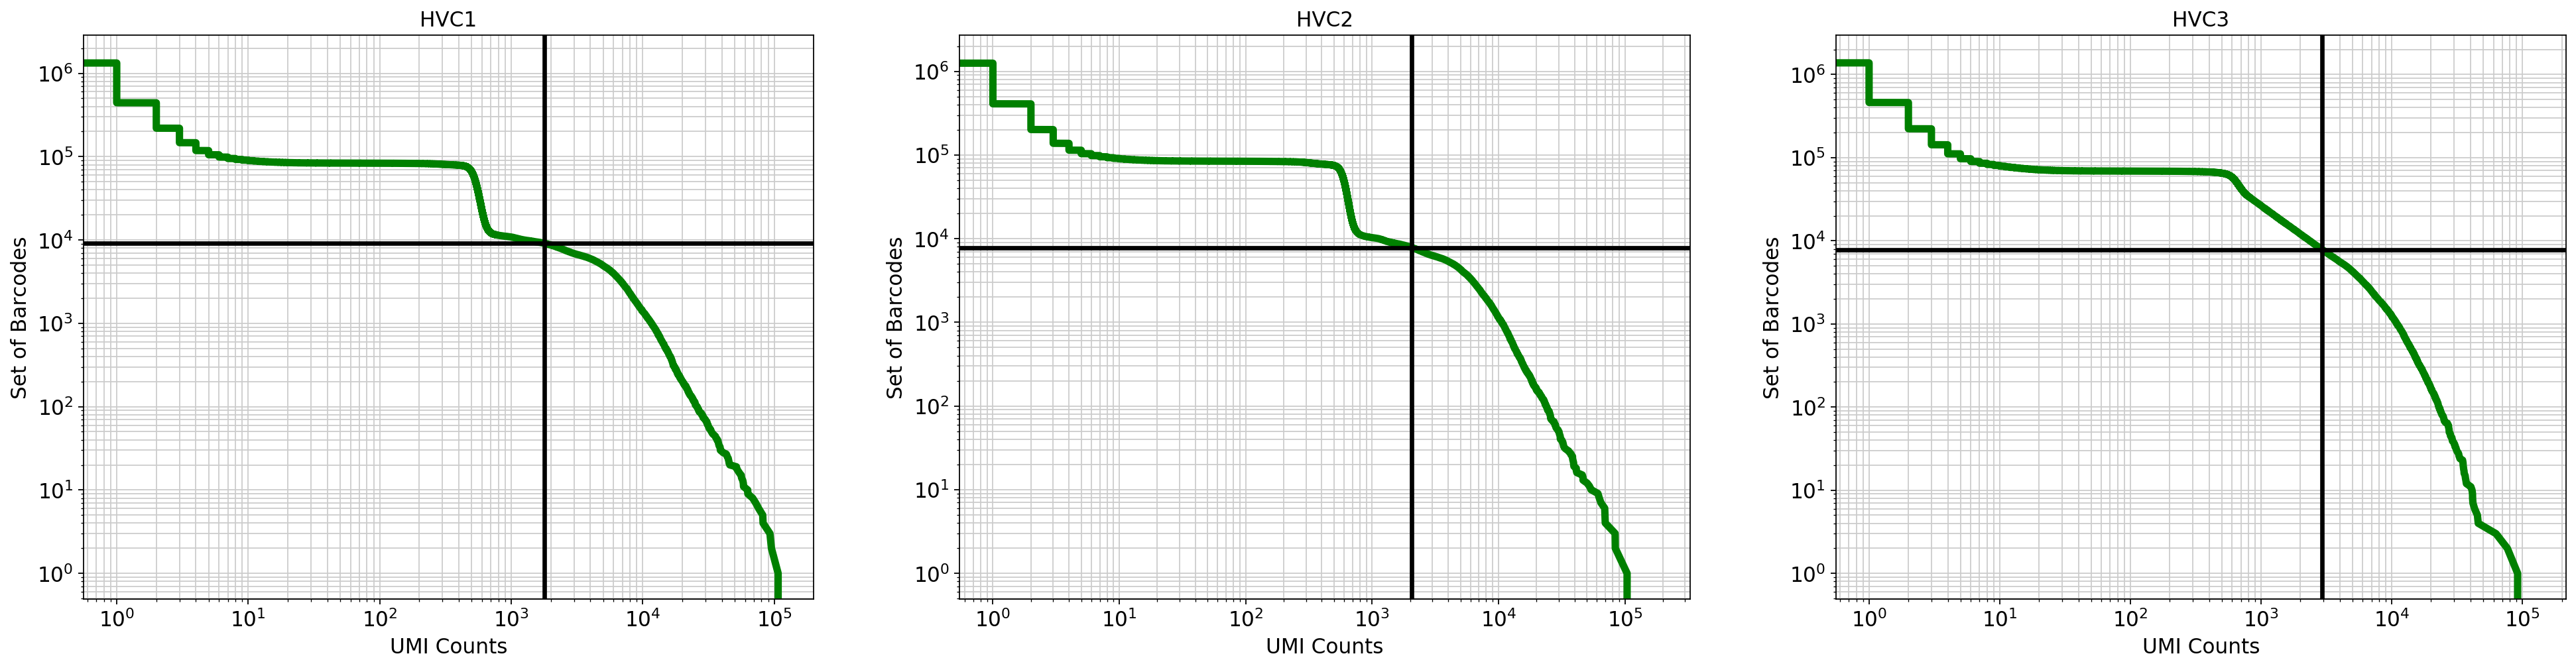

In [17]:
fig, axs = plt.subplots(figsize=(30,7), ncols=3)
i = 0

for ax,adata in zip(axs, adatas):

    knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
    
    ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
    ax.axvline(x=knee[expected_num_cells[i]], linewidth=3, color="k")
    ax.axhline(y=expected_num_cells[i], linewidth=3, color="k")

    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Set of Barcodes")
    ax.set_title("{}".format(adata.obs.batch.values[0]))
    
    ax.grid(True, which="both")
    
    i =+ 1

fig.show()

Knee plot ref: https://liorpachter.wordpress.com/2019/06/24/rotating-the-knee-plot-and-related-yoga/

Filtering based on knee plot:

In [19]:
adatas = []

for i, adata in enumerate(adatas_raw):
    knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
    min_umi = knee[expected_num_cells[i]]
    print("The minimum number of UMI counts based on the knee plot for {} is: ".format(adata.obs.batch[0])+str(min_umi))

    # Removes cells with less than min_umi umi counts
    adata_new = adata[np.asarray(adata.X.sum(axis=1)).reshape(-1) > min_umi]

    # Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
    adata_new.obs['n_counts_processed'] = adata_new.X.sum(axis=1)
    
    adatas.append(adata_new)

Trying to set attribute `.obs` of view, copying.


The minimum number of UMI counts based on the knee plot for HVC1 is: 1777.0


Trying to set attribute `.obs` of view, copying.


The minimum number of UMI counts based on the knee plot for HVC2 is: 2064.0


Trying to set attribute `.obs` of view, copying.


The minimum number of UMI counts based on the knee plot for HVC3 is: 5305.0


#### Mean UMIs for each batch

In [20]:
for adata in adatas:
    print("Mean UMI count per cell for {}: ".format(adata.obs.batch.values[0]) + str(adata.X.sum(axis=1).mean()))

Mean UMI count per cell for HVC1: 6585.203
Mean UMI count per cell for HVC2: 6591.1953
Mean UMI count per cell for HVC3: 9619.932


n_obs is pretty close to the expected number of cells (approx 10k).

___

# Data quality check

### Test for library saturation

In [21]:
# Function to add linear graph NOTE: call yex after defining x and y scale !!!
def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set(**{
        "aspect": "equal",
        "xlim": lims,
        "ylim": lims
    })
    return ax

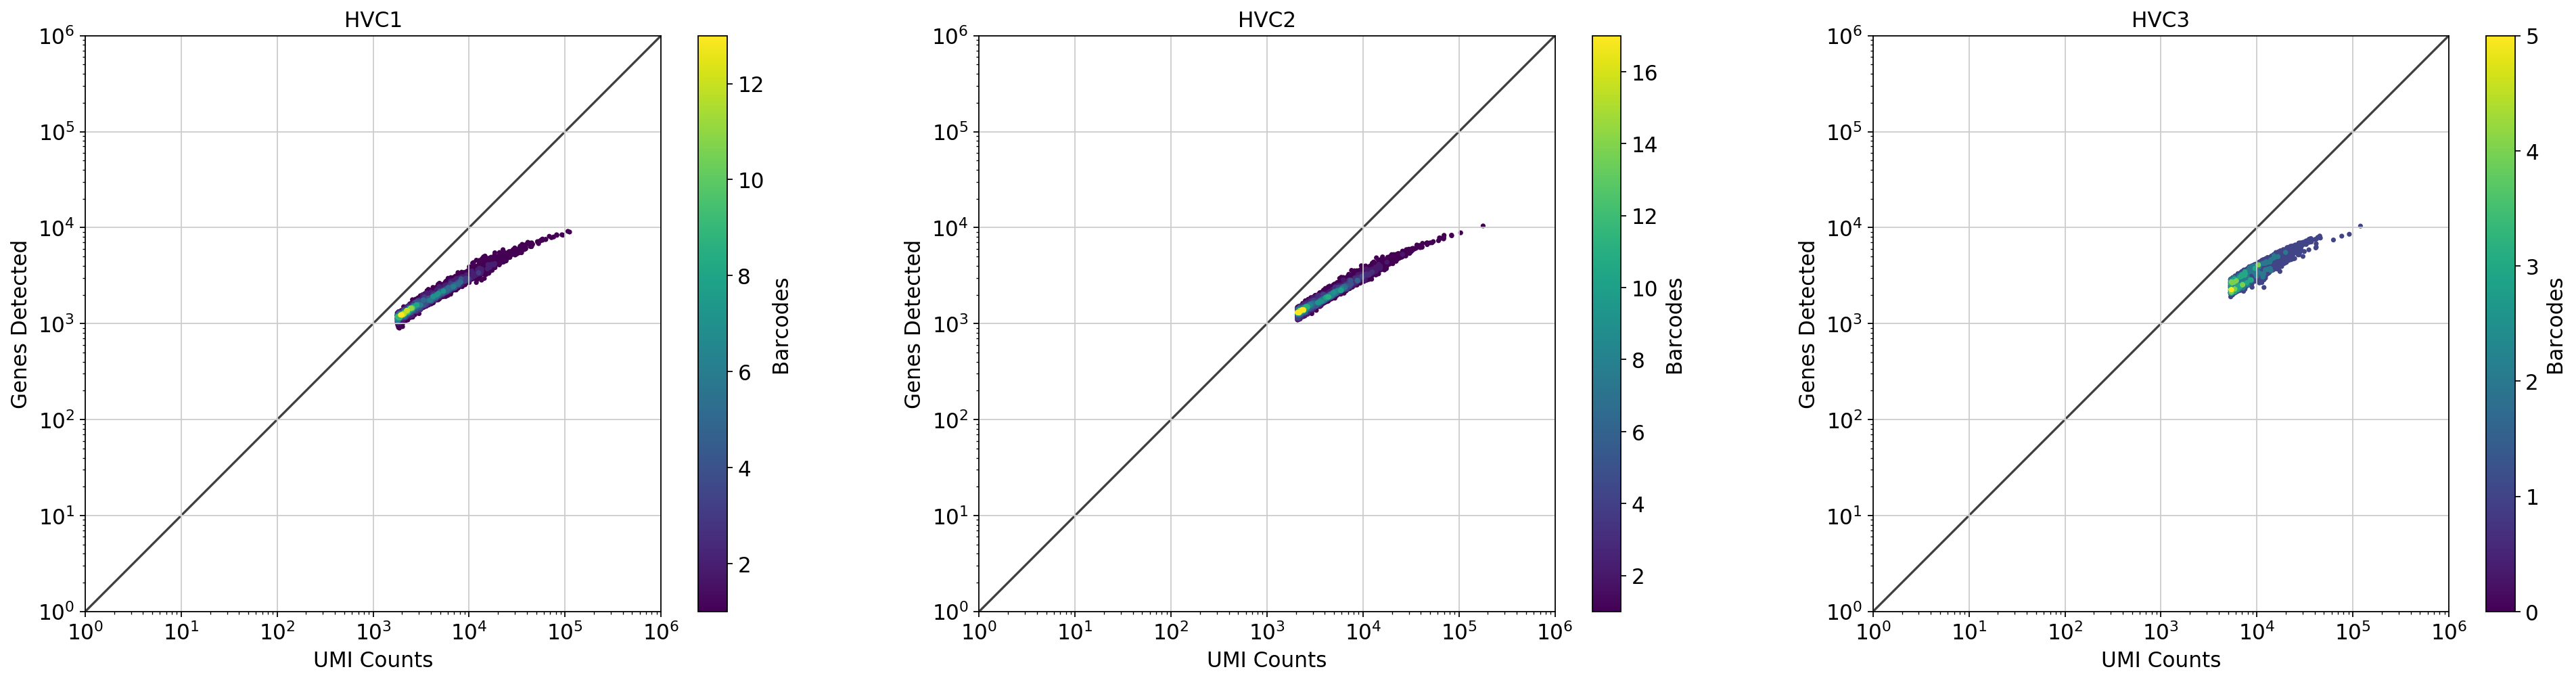

In [23]:
fig, axs = plt.subplots(figsize=(30,7), ncols=3)

for ax,adata in zip(axs, adatas):
    x = np.asarray(adata.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

    #histogram definition
    bins = [1500, 1500] # number of bins

    # histogram the data
    hh, locx, locy = np.histogram2d(x, y, bins=bins)

    # Sort the points by density, so that the densest points are plotted last
    z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
    idx = z.argsort()
    x2, y2, z2 = x[idx], y[idx], z[idx]


    scatter = ax.scatter(x2, y2, c=z2, s=5, cmap='viridis')  
    fig.colorbar(scatter, ax=ax, label="Barcodes")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    ax.set_title("{}".format(adata.obs.batch.values[0]))

    yex(ax)

fig.show()

For reference: This is what a more saturated data set looks like https://github.com/pachterlab/BYVSTZP_2020/blob/master/analysis/notebooks/final-10x_saturation_curves.ipynb

### Overlay expression of mito/apoptosis genes to see if extra arm contains dying cells

Mitochondrial/apoptosis marker genes: MCU (ENSTGUG00000004428), AIFM1 (ENSTGUG00000005167), CASP3 (ENSTGUG00000006682)

In [24]:
def nd(arr):
    """
    Funciton to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

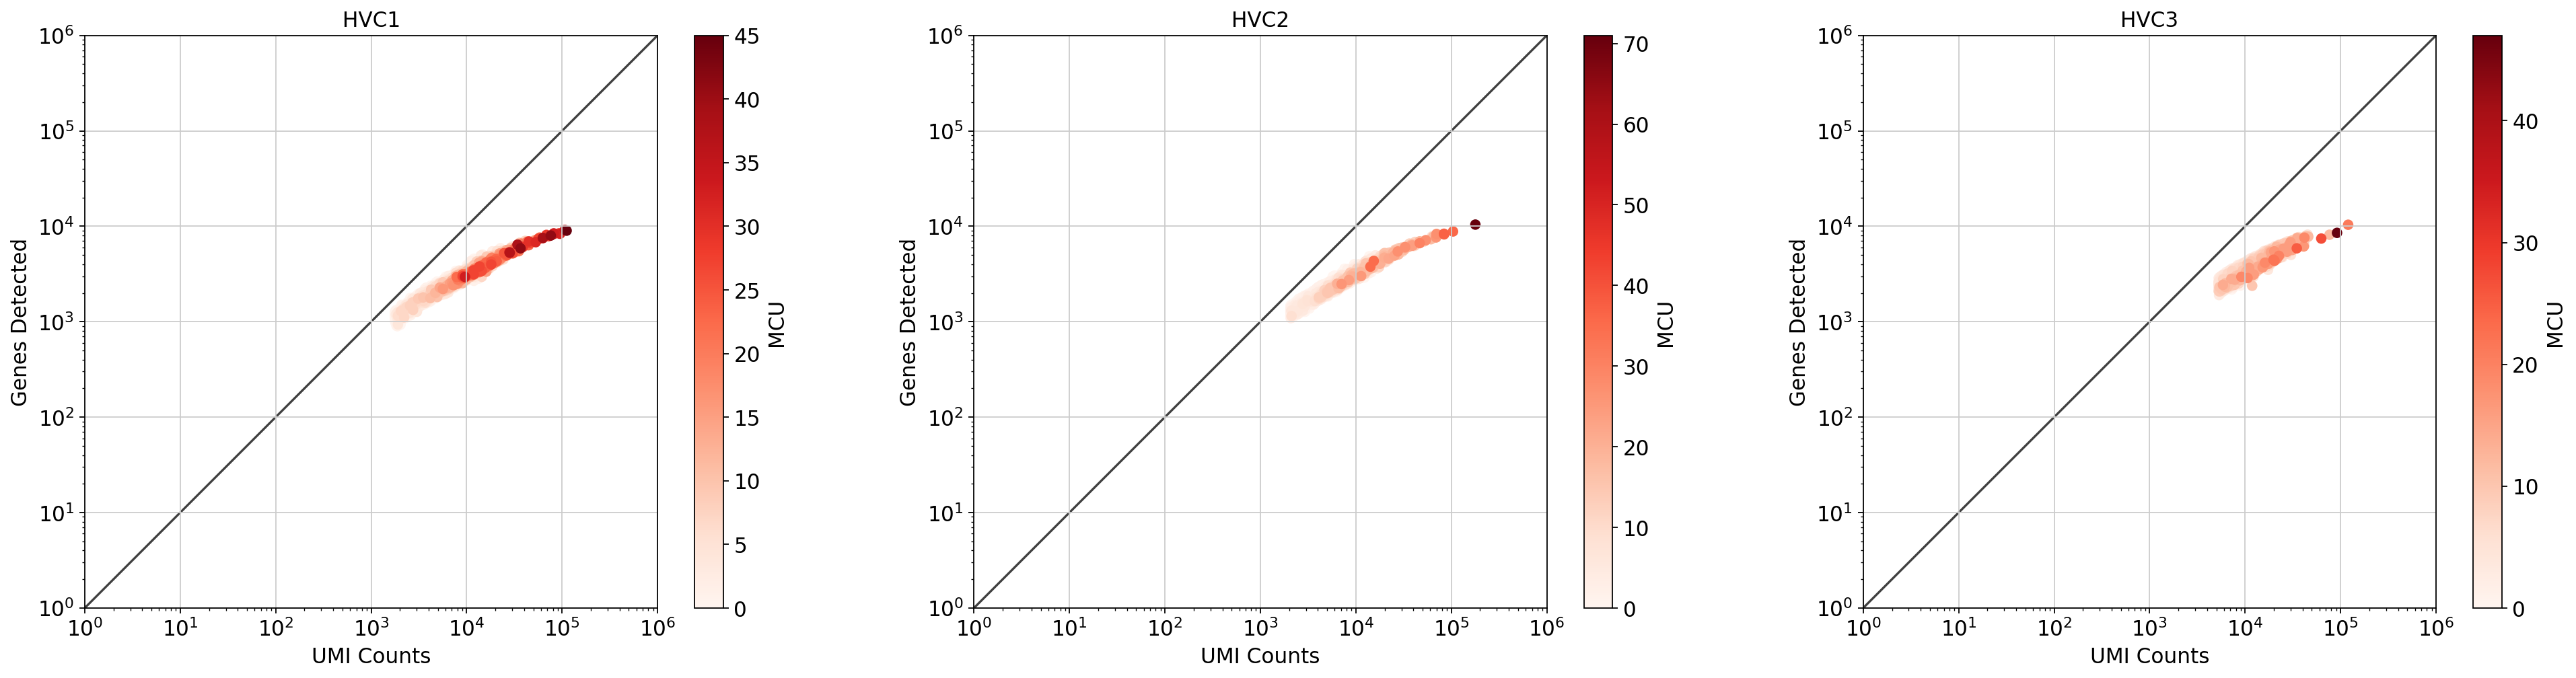

In [25]:
fig, axs = plt.subplots(figsize=(30,7), ncols=3)

for ax,adata in zip(axs, adatas):

    x = nd(adata.X.sum(1))
    y = nd((adata.X>0).sum(1))
    c = nd(adata[:, adata.var.index.str.contains("ENSTGUG00000004428")].X.todense())
    idx = c.argsort()
    x2, y2, c2 = x[idx], y[idx], c[idx]
    scatter = ax.scatter(x2, y2, c=c2, cmap="Reds")
    fig.colorbar(scatter, ax=ax, label="MCU")
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    ax.set_title("{}".format(adata.obs.batch.values[0]))
    yex(ax)

fig.show()

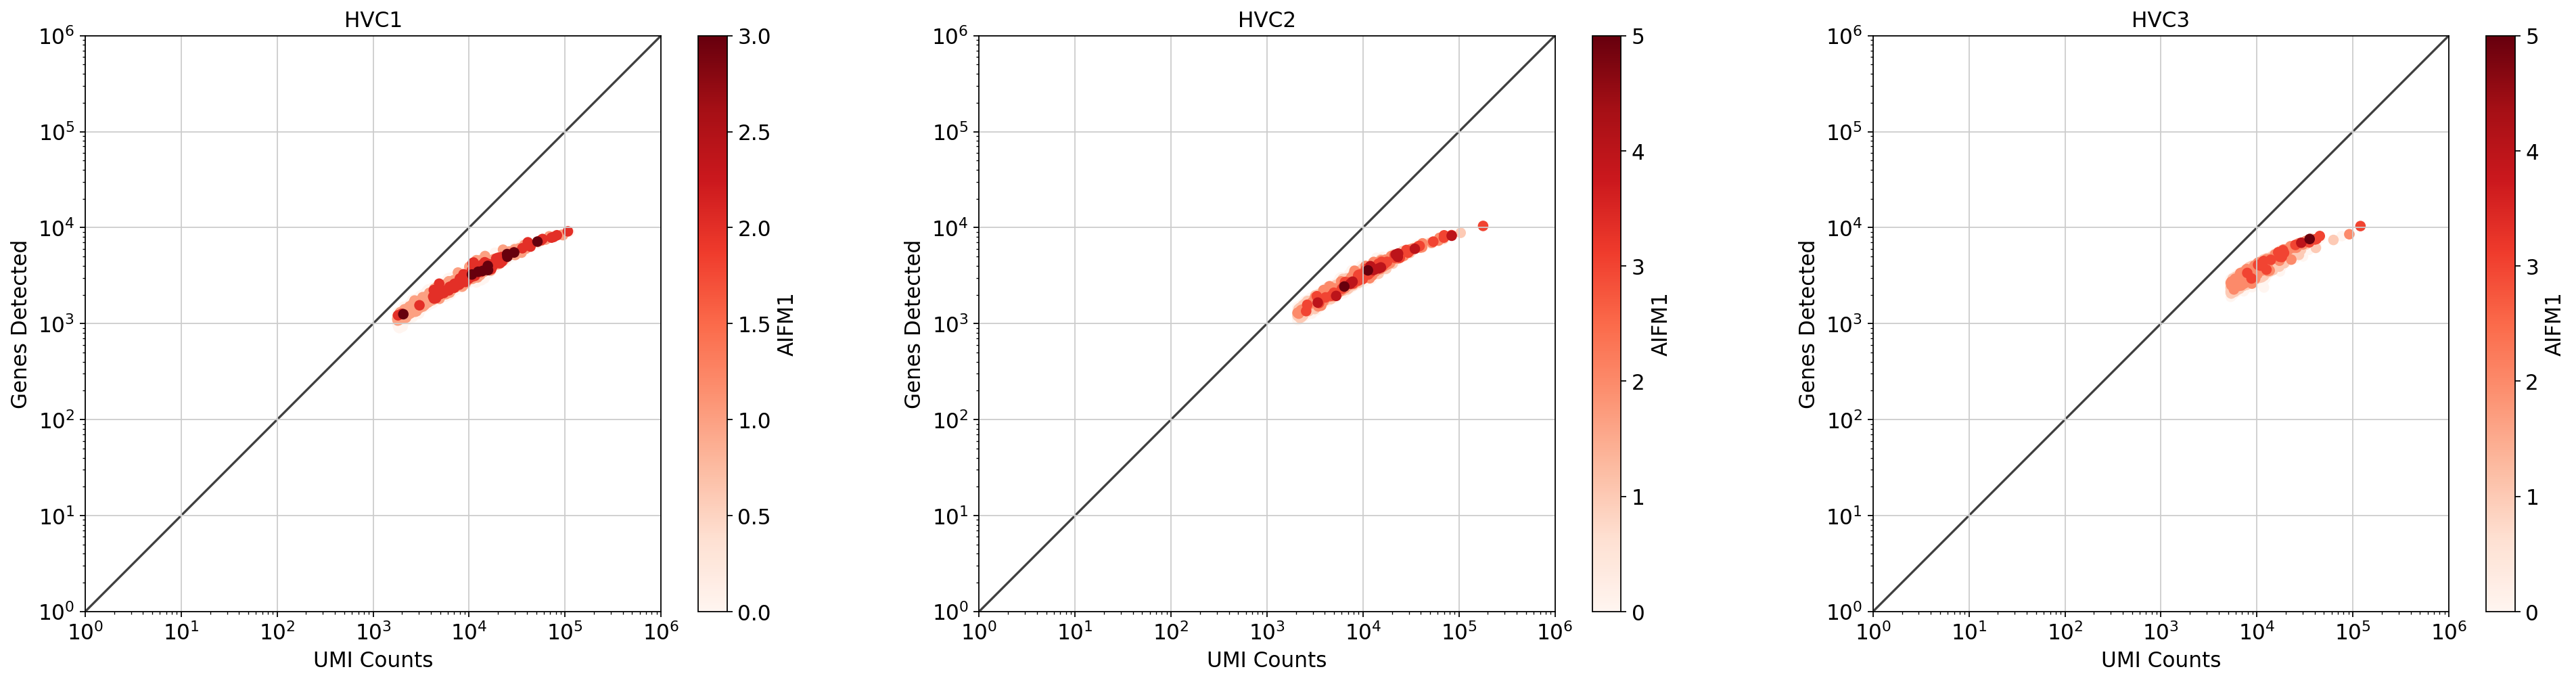

In [28]:
fig, axs = plt.subplots(figsize=(30,7), ncols=3)

for ax,adata in zip(axs, adatas):

    x = nd(adata.X.sum(1))
    y = nd((adata.X>0).sum(1))
    c = nd(adata[:, adata.var.index.str.contains("ENSTGUG00000005167")].X.todense())
    idx = c.argsort()
    x2, y2, c2 = x[idx], y[idx], c[idx]
    scatter = ax.scatter(x2, y2, c=c2, cmap="Reds")
    fig.colorbar(scatter, ax=ax, label="AIFM1")
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    ax.set_title("{}".format(adata.obs.batch.values[0]))
    yex(ax)

fig.show()

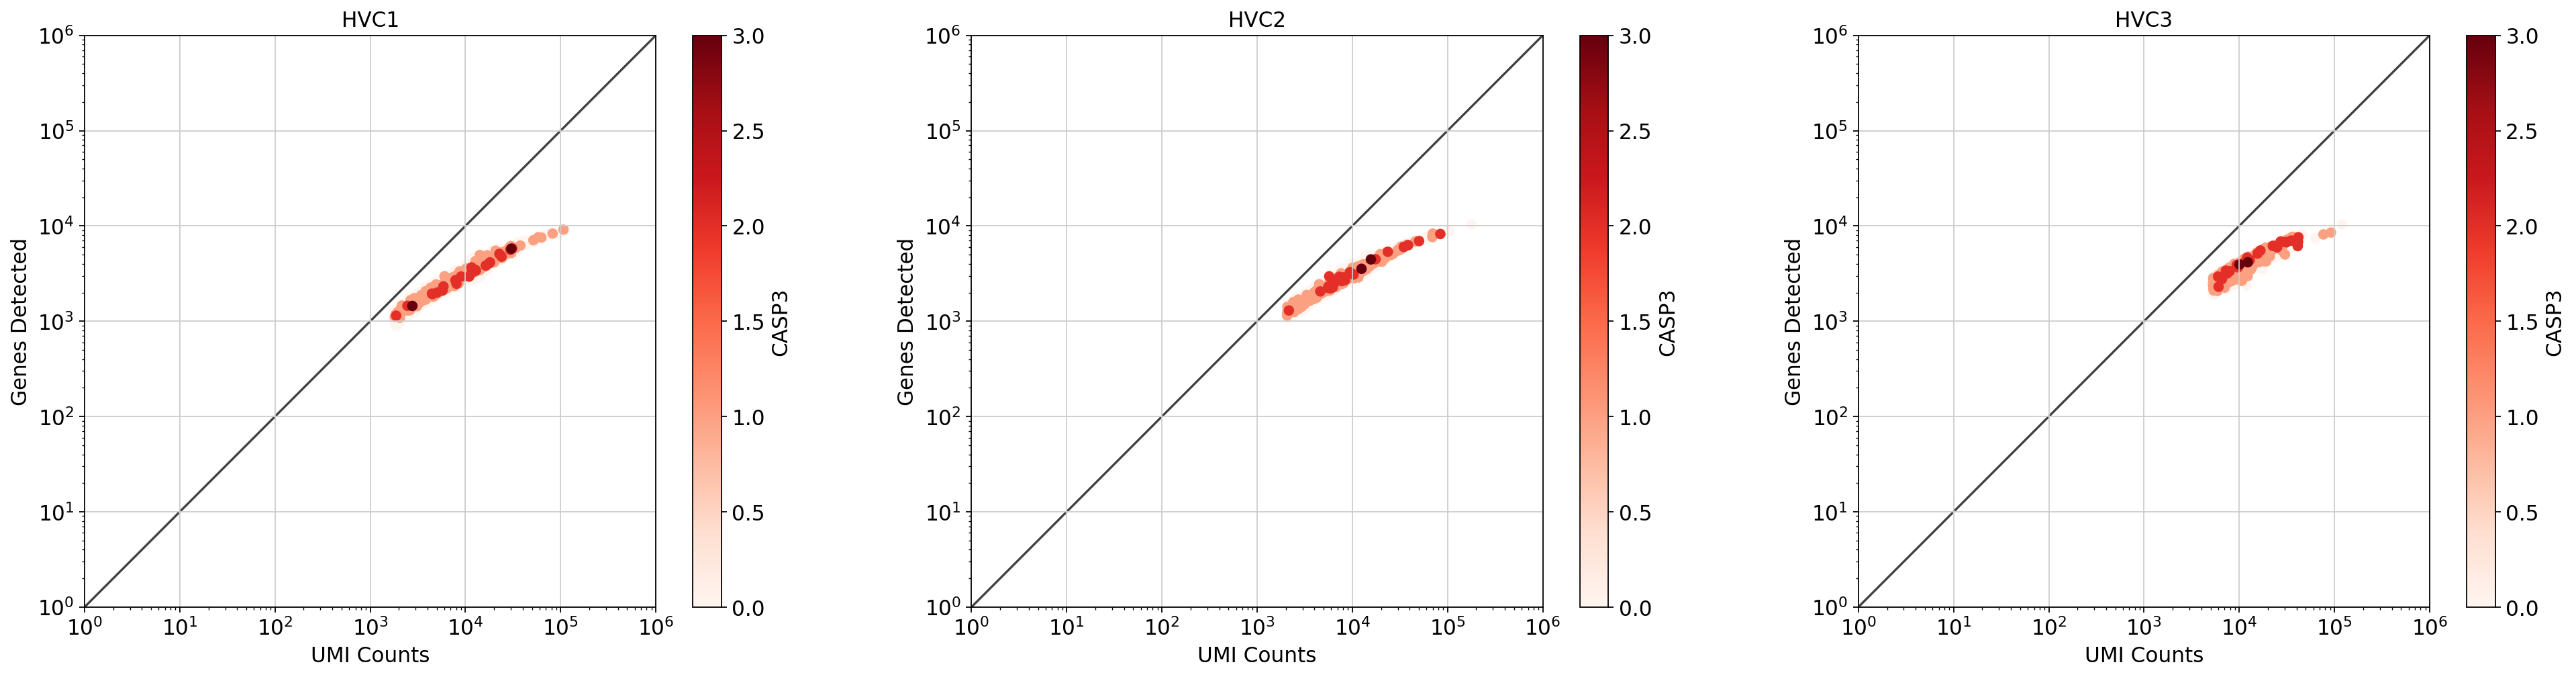

In [29]:
fig, axs = plt.subplots(figsize=(30,7), ncols=3)

for ax,adata in zip(axs, adatas):

    x = nd(adata.X.sum(1))
    y = nd((adata.X>0).sum(1))
    c = nd(adata[:, adata.var.index.str.contains("ENSTGUG00000006682")].X.todense())
    idx = c.argsort()
    x2, y2, c2 = x[idx], y[idx], c[idx]
    scatter = ax.scatter(x2, y2, c=c2, cmap="Reds")
    fig.colorbar(scatter, ax=ax, label="CASP3")
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    ax.set_title("{}".format(adata.obs.batch.values[0]))
    yex(ax)

fig.show()

Based on the low UMI counts of these markers the cells look very healthy. It does not look like the cells in the second arm express these apoptosis and mitochondrial marker genes at a higher level than other cells.

___

# Concatenate AnnData objects (per experiment condition)

In [39]:
# Join = outer uses union of datasets (not just intersection); empty values will be filled with np.nan
adata_control = adata_1C.concatenate(adata_2C, 
                                     join='outer', 
                                     batch_key='batch_index', 
                                     batch_categories=None, 
                                     uns_merge=None, 
                                     fill_value=np.nan)

In [40]:
# Join = outer uses union of datasets (not just intersection); empty values will be filled with np.nan
adata_experiment = adata_3E.concatenate(adata_4E, 
                                        join='outer', 
                                        batch_key='batch_index', 
                                        batch_categories=None, 
                                        uns_merge=None, 
                                        fill_value=np.nan)

In [41]:
# Add column containing sum of molecules across all genes
adata_control.obs["n_counts_raw"] = adata_control.X.sum(axis=1)
adata_experiment.obs["n_counts_raw"] = adata_experiment.X.sum(axis=1)

In [42]:
# Create new index consisting of gene_name and gene_id separated by "_" (previous index was just gene_id)
adata_control.var["gene_id"] = adata_control.var.index.values
adata_control.var.index = adata_control.var.gene_name.astype(str) + "_" + adata_control.var.gene_id.astype(str)
del adata_control.var["gene_id"]

adata_experiment.var["gene_id"] = adata_experiment.var.index.values
adata_experiment.var.index = adata_experiment.var.gene_name.astype(str) + "_" + adata_experiment.var.gene_id.astype(str)
del adata_experiment.var["gene_id"]

In [43]:
# Create copy of raw count (after basic filtering) information for scvi-tools
adata_control_scvi = adata_control.copy()
adata_experiment_scvi = adata_experiment.copy()

___

# Normalization (per experiment condition)

Show highest expressing genes before normalization:

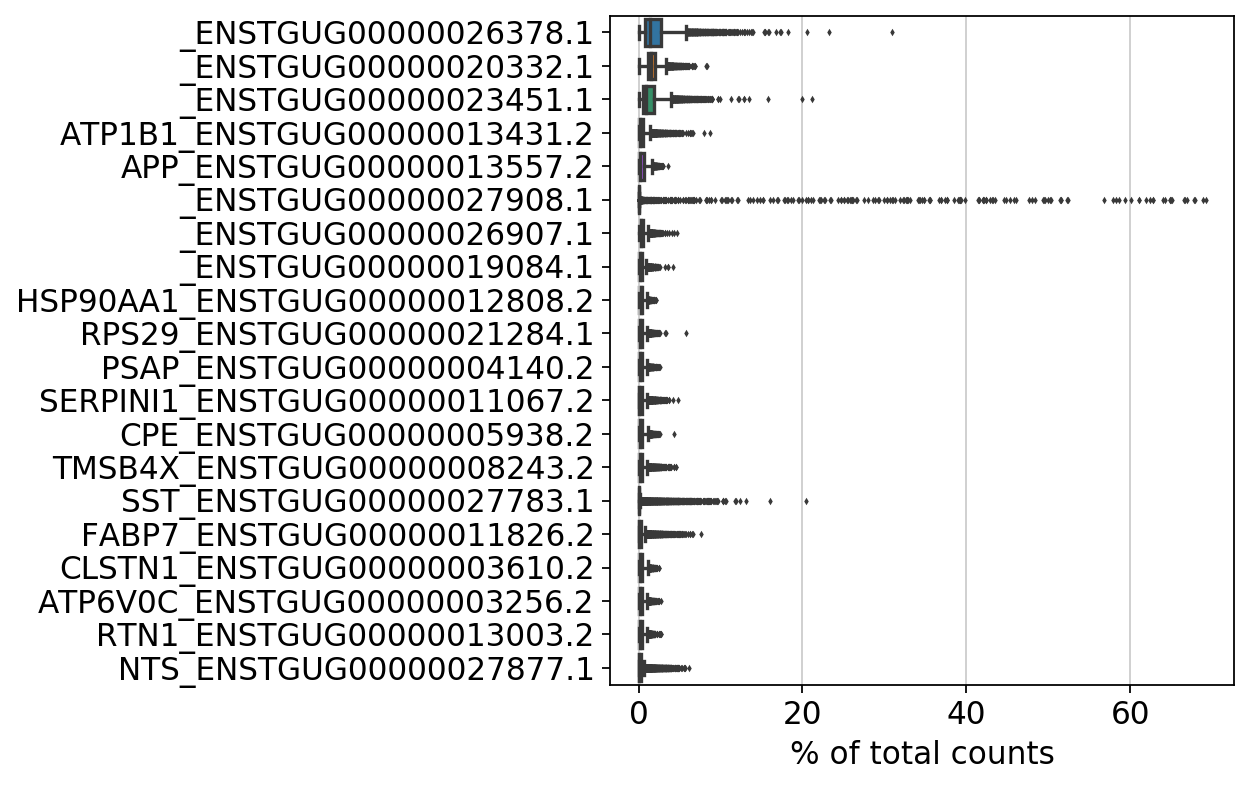

In [44]:
sc.pl.highest_expr_genes(adata_control, n_top=20)

Divide each gene count by the total # of UMI's for that cell. Then take log(X+1) (+1 because you cannot take log(0)) (=log transformation). Note: Doing CP10k instead of CPM because Leiden clustering gives ~50 clusters if I use CPM for some unkown reason.

In [45]:
adata_control.layers["raw"] = adata_control.X.copy()
sc.pp.normalize_total(adata_control, target_sum=10**4) # CP10k normalization: sum counts for each cell, divide each entry by this sum, multiply by 10k
sc.pp.log1p(adata_control) # log(expression + 1)

Highest expressed genes after normalization and log:

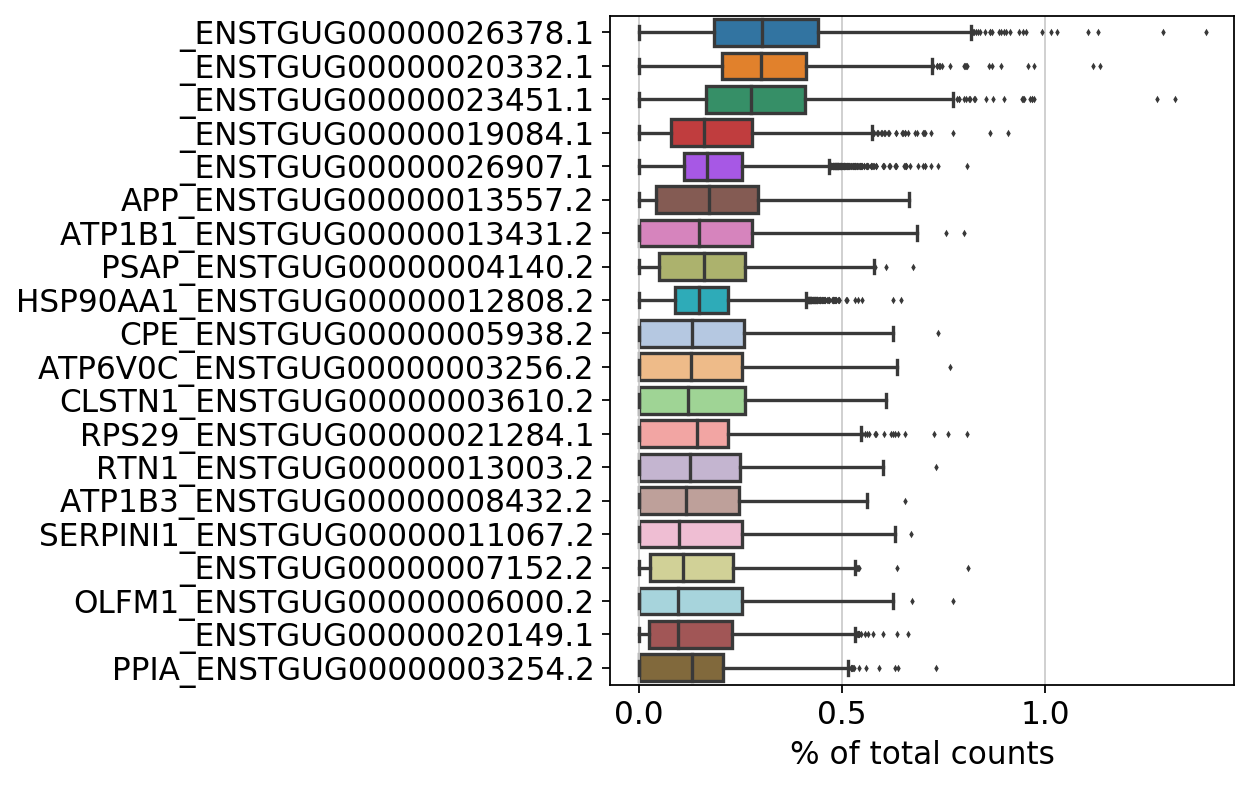

In [46]:
sc.pl.highest_expr_genes(adata_control, n_top=20)

Annotate highly variable genes:

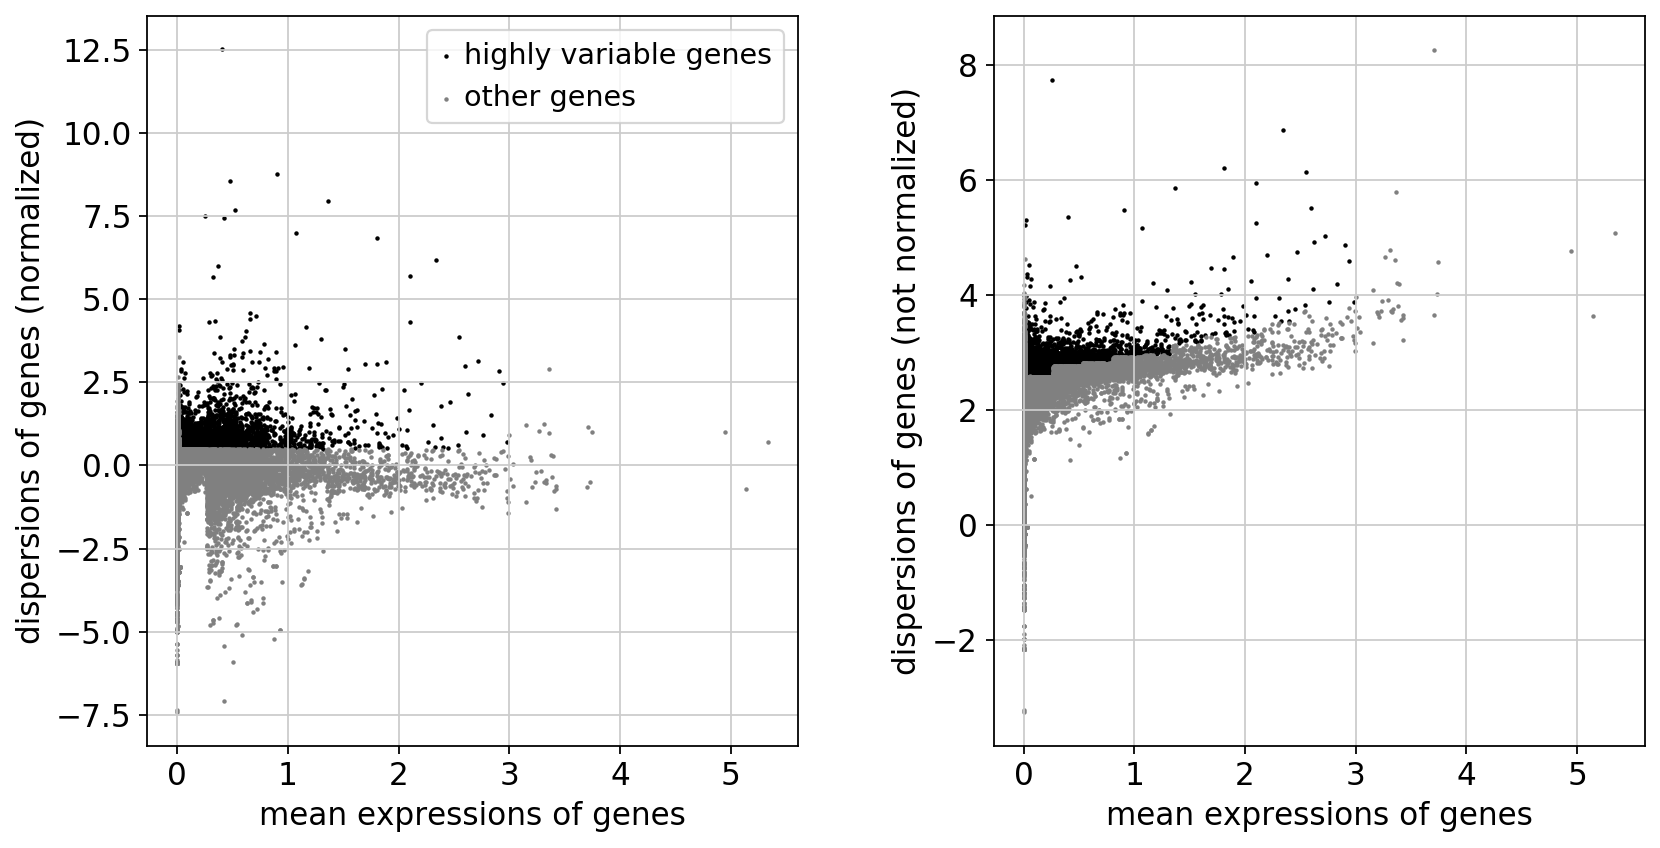

In [47]:
sc.pp.highly_variable_genes(adata_control)
sc.pl.highly_variable_genes(adata_control)

Same for experiment adata:

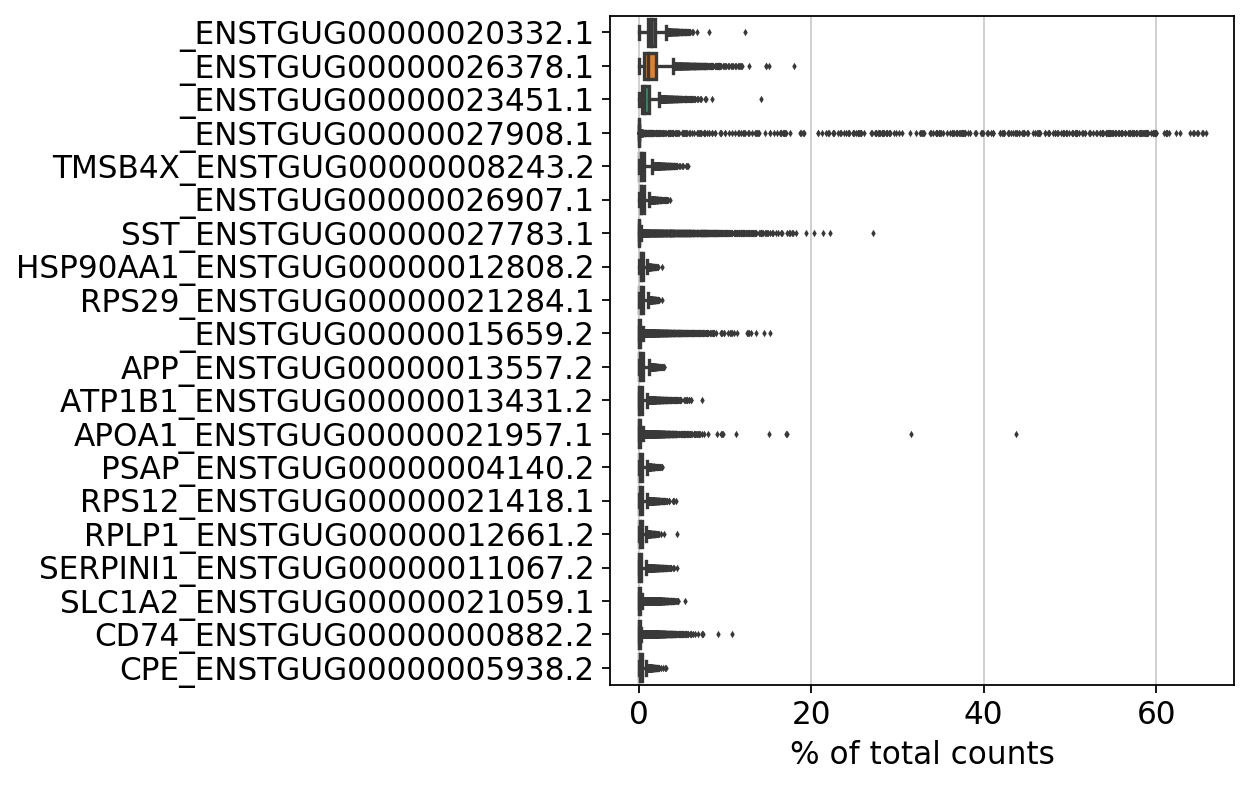

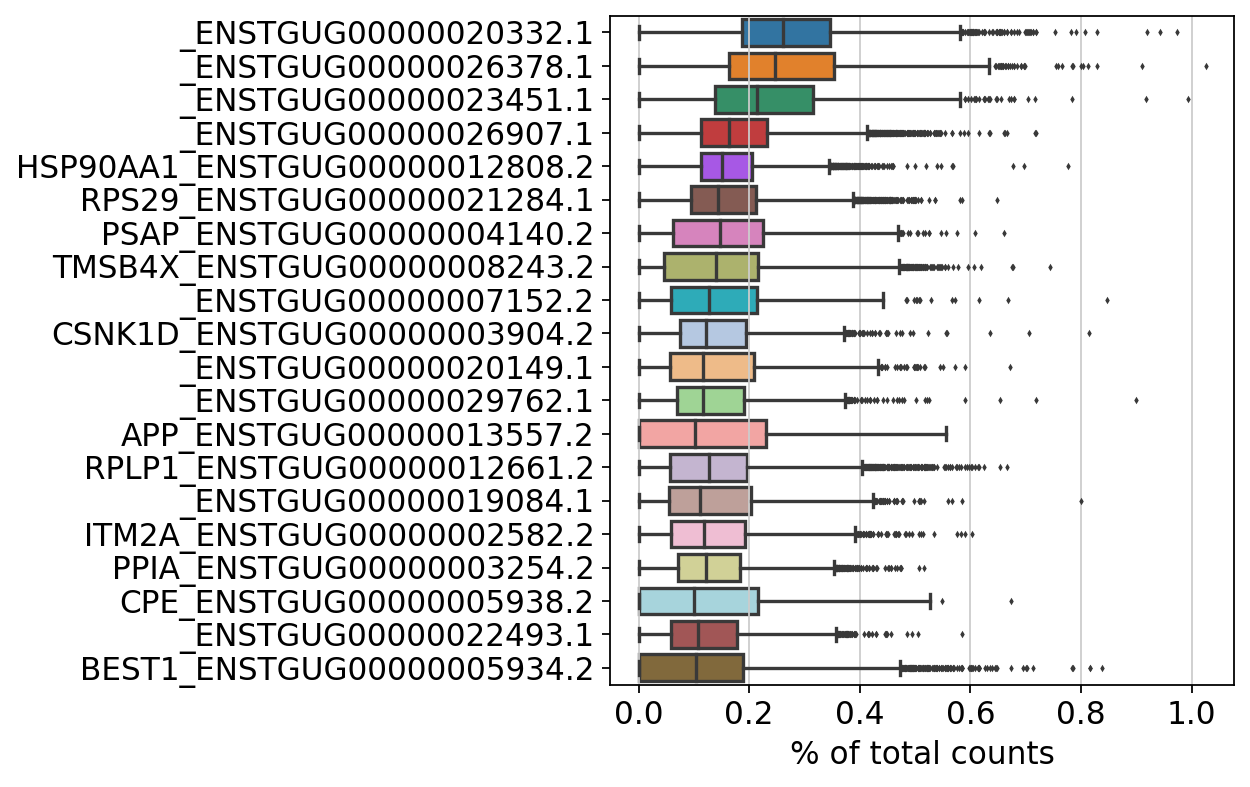

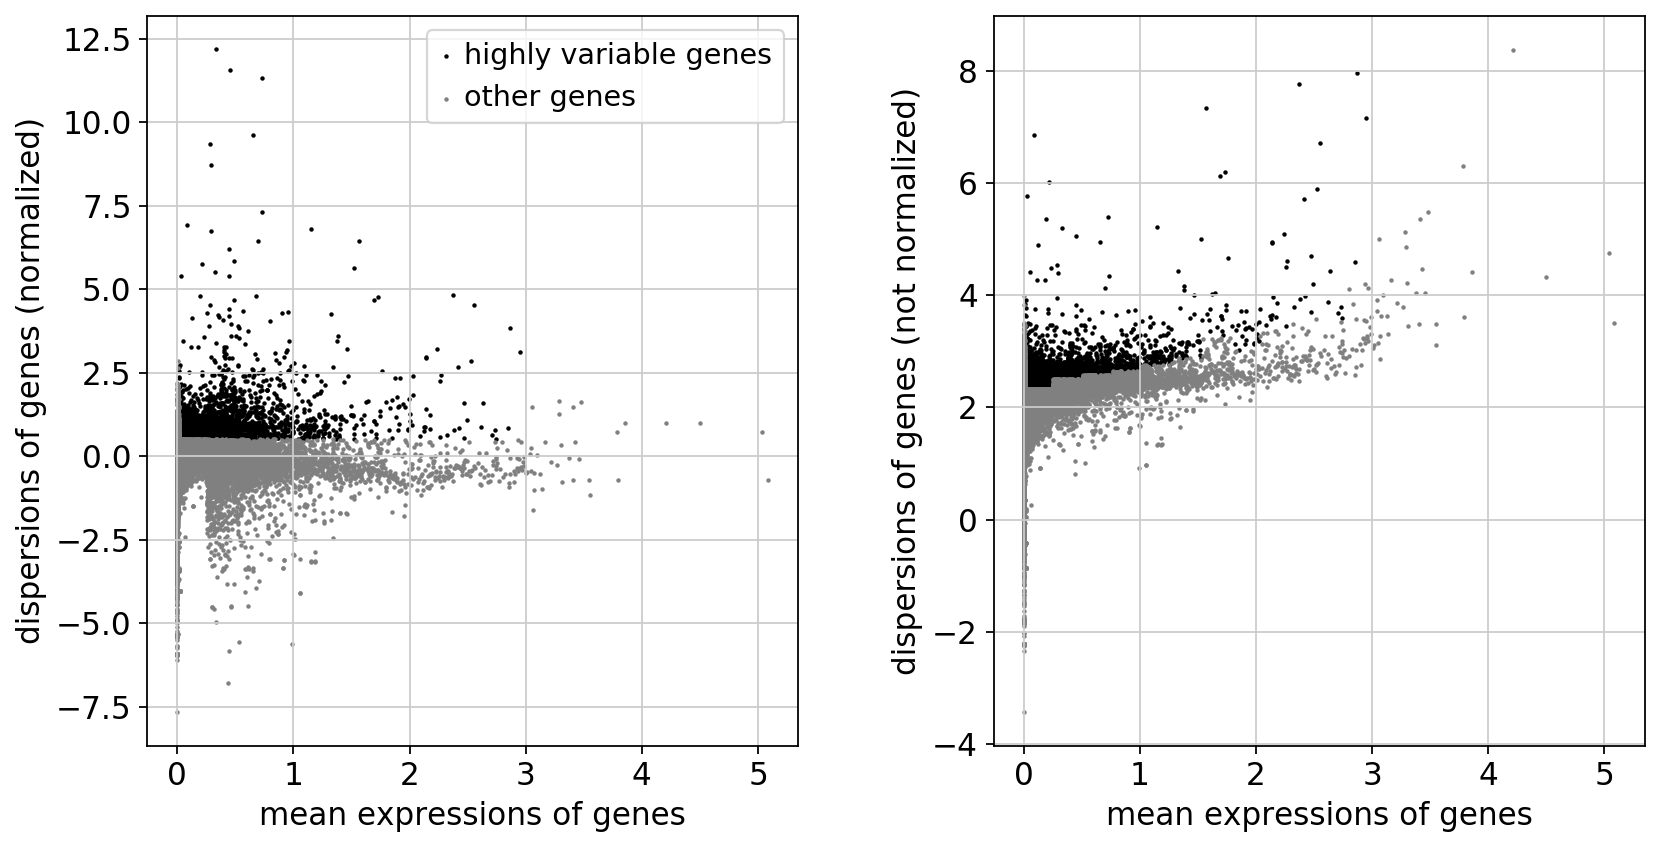

In [48]:
sc.pl.highest_expr_genes(adata_experiment, n_top=20)
adata_experiment.layers["raw"] = adata_experiment.X.copy()
sc.pp.normalize_total(adata_experiment, target_sum=10**4) # CP10k (Counts Per 10k) normalization: sum counts for each cell, divide each entry by this sum, multiply by 10k
sc.pp.log1p(adata_experiment) # log(expression + 1)
sc.pl.highest_expr_genes(adata_experiment, n_top=20)
sc.pp.highly_variable_genes(adata_experiment)
sc.pl.highly_variable_genes(adata_experiment)

___

# PCA (per experiment condition)

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [49]:
# Perform PCA on just the highly variable genes
sc.tl.pca(adata_control, use_highly_variable=True)
sc.tl.pca(adata_experiment, use_highly_variable=True)

Plot the variance ratio:

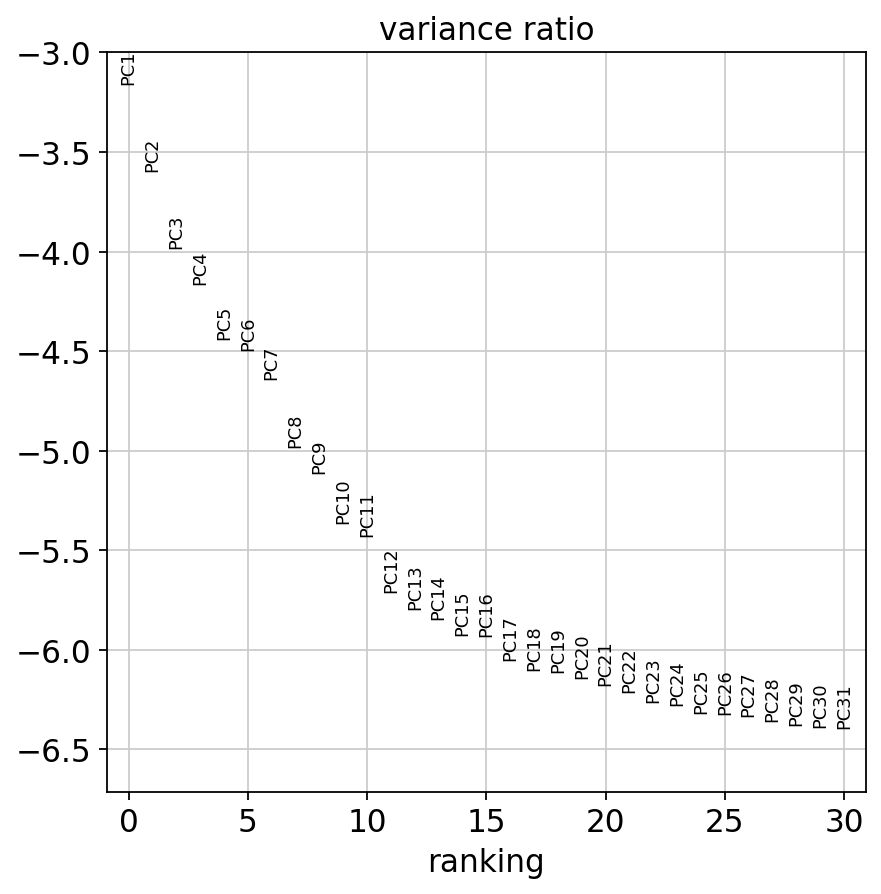

In [50]:
# Control
sc.pl.pca_variance_ratio(adata_control, log=True)

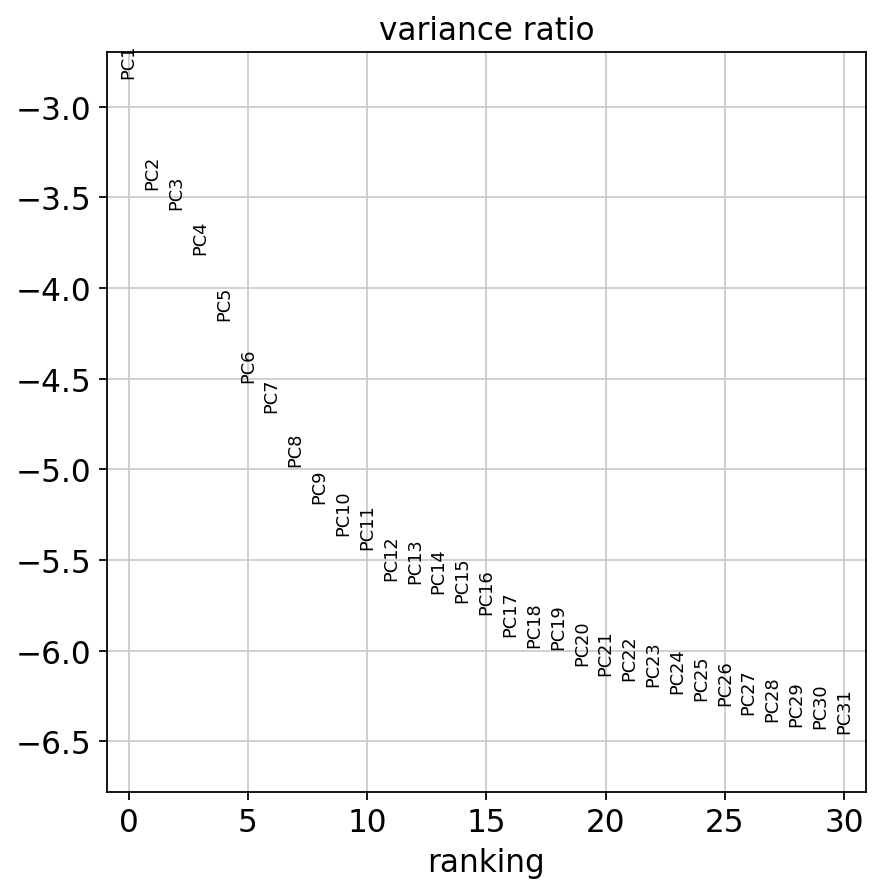

In [51]:
# Experiment
sc.pl.pca_variance_ratio(adata_experiment, log=True)

# UMAP (per experiment condition)

In [52]:
# Define number of nearest neighbours based on the variance ratio plot above
n_neighbors = 20
n_pcs=10

In [53]:
# Find nearest neighbors
sc.pp.neighbors(adata_control, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Project leiden clustering into 2D
sc.tl.umap(adata_control)

Same for experiment data:

In [54]:
# Find nearest neighbors
sc.pp.neighbors(adata_experiment, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Project leiden clustering into 2D
sc.tl.umap(adata_experiment)

# Leiden clustering (per experiment condition)

In [55]:
# Leiden clustering on the neighboorhood graph
sc.tl.leiden(adata_control)
sc.tl.leiden(adata_experiment)

___

# Examine batch effects within replicates

## Controls

... storing 'species' as categorical
... storing 'batch' as categorical


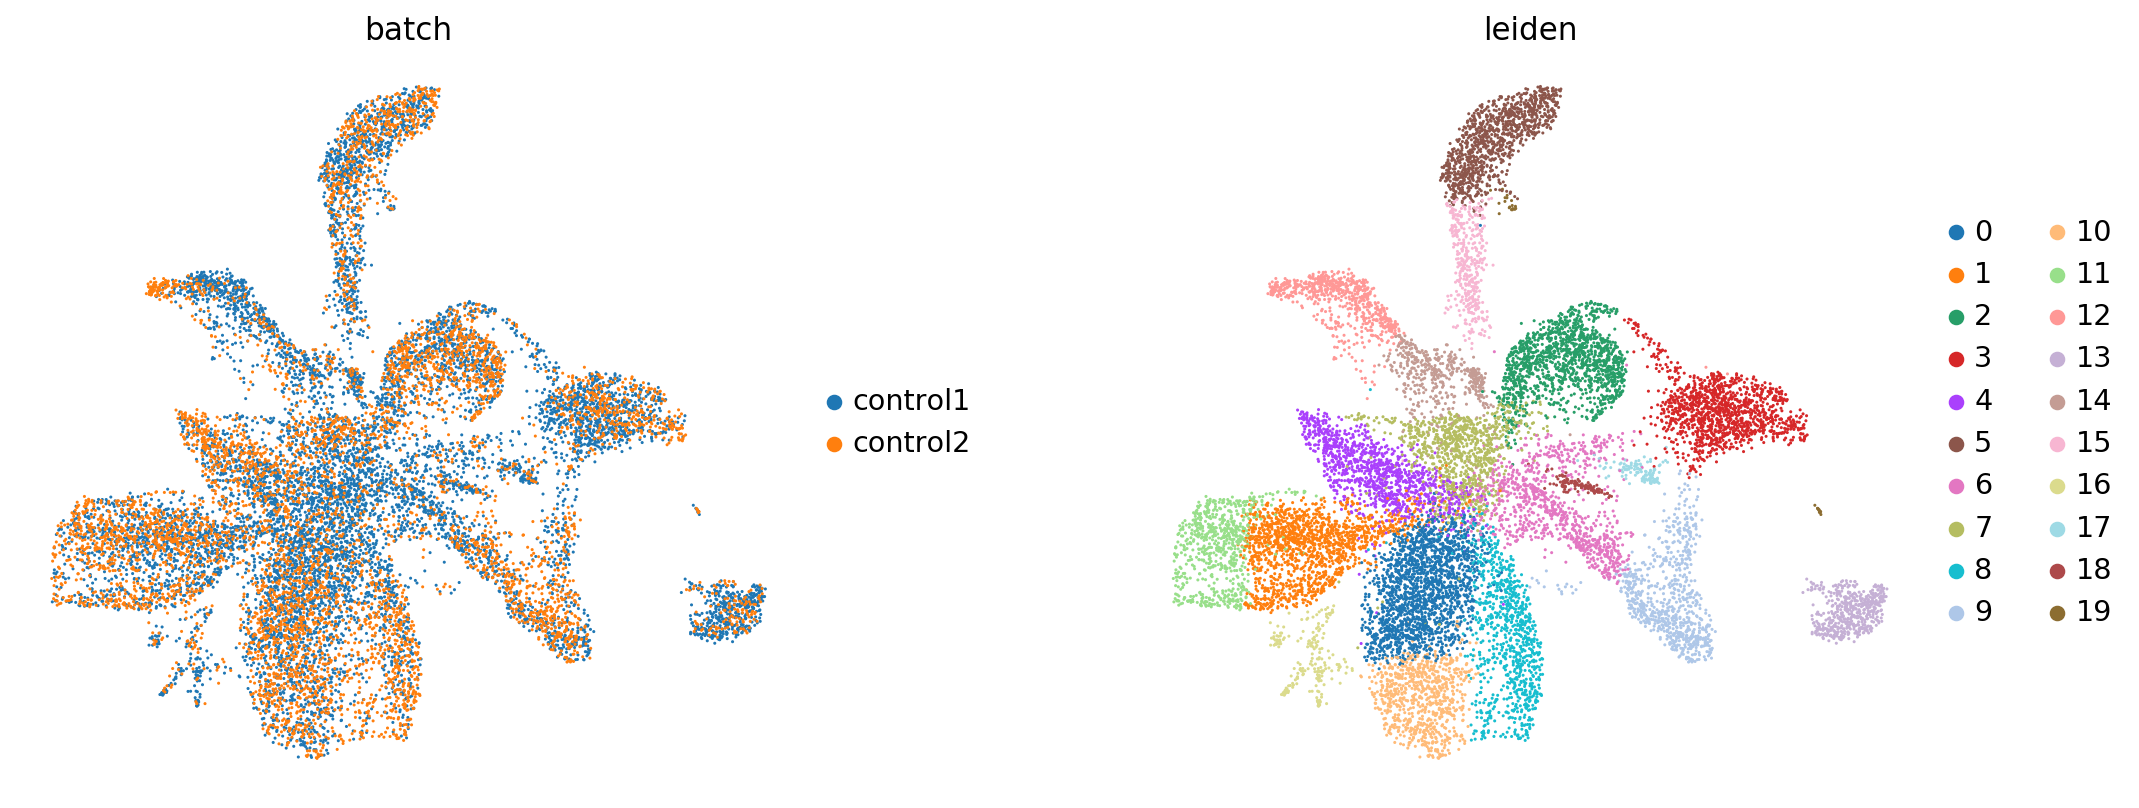

In [56]:
# Plot UMAP and color by Leiden clusters and batch
sc.pl.umap(adata_control, 
           color=["batch", "leiden"],
           wspace=0.3
          )

Plot fraction of each batch per cluster (after normalizing to total cellcount in each batch):

In [57]:
# Normalize each celltype count to total number of cells in that batch by dividing
df_control = (adata_control.obs.groupby("leiden")["batch"].value_counts() / adata_control.obs.groupby("batch")["species"].count()).unstack().fillna(0)
# The above returns a categorical dataframe, so we will convert the columns to strings
df_control.columns = df_control.columns.astype(str)

df_control["total normalized count"] = df_control.sum(axis=1).values

df_control["control1_fraction"] = (df_control["control1"] / df_control["total normalized count"]).values
df_control["control2_fraction"] = (df_control["control2"] / df_control["total normalized count"]).values

df_control["total number of cells"] = adata_control.obs.groupby("leiden").size().values.astype(int)

df_control.head()

batch   control1  control2  total normalized count  control1_fraction  \
leiden                                                                  
0       0.123937  0.100546                0.224483           0.552101   
1       0.093516  0.095419                0.188936           0.494964   
2       0.078357  0.101538                0.179895           0.435571   
3       0.087883  0.067637                0.155520           0.565091   
4       0.067500  0.078055                0.145555           0.463741   

batch   control2_fraction  total number of cells  
leiden                                            
0                0.447899                   1818  
1                0.505036                   1490  
2                0.564429                   1379  
3                0.434909                   1267  
4                0.536259                   1131

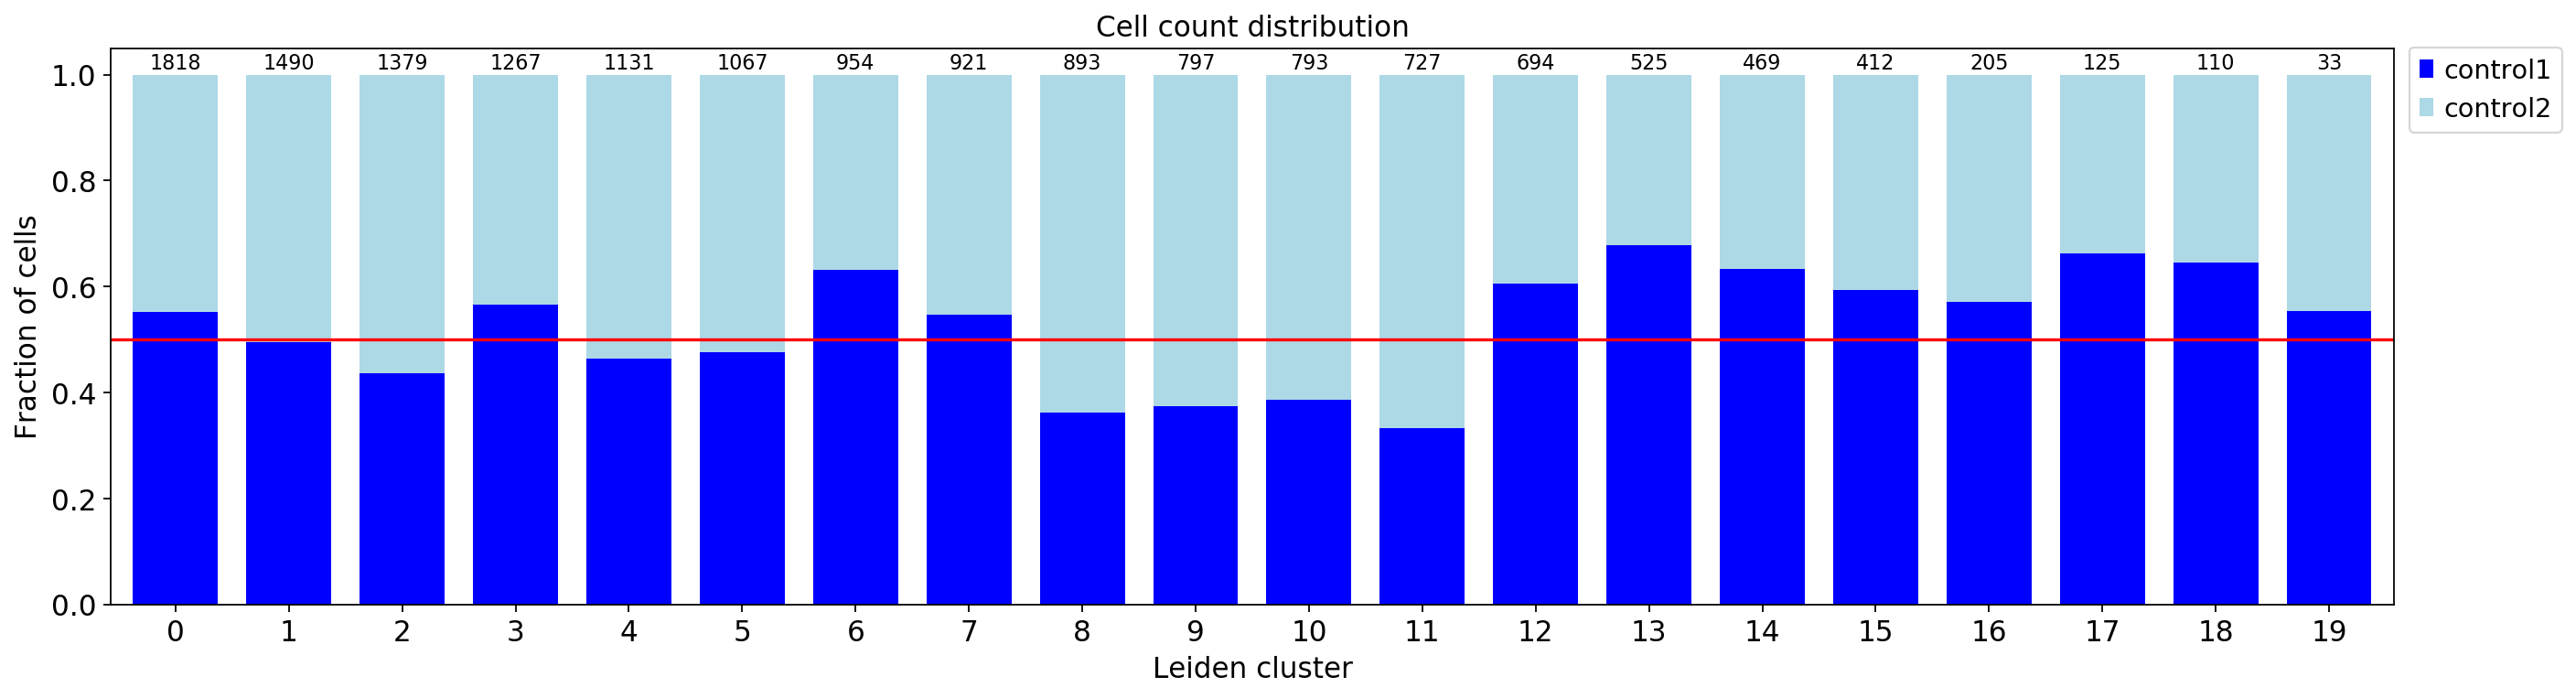

In [58]:
fig, ax = plt.subplots(figsize=(20,5))

clusters = df_control.index.values
width = 0.75

ax.bar(clusters, df_control["control1_fraction"].values, width, color="blue", label="control1")
ax.bar(clusters, df_control["control2_fraction"].values, width, bottom=df_control["control1_fraction"].values, color="lightblue", label="control2")

cellcounts = df_control["total number of cells"].values
# Add total cell count above each bar
for index, value in enumerate(cellcounts):
    ax.text(x = index, y = 1.01, s = value, size = 10, ha='center')

ax.set_xticklabels(clusters, rotation = 0, ha="center")
ax.legend(bbox_to_anchor=(1.001, 1.025), loc='upper left')

ax.set(**{
    "title": "Cell count distribution",
    "ylabel": "Fraction of cells",
    "xlabel": "Leiden cluster"
})

ax.axhline(y=0.5, color='r', linestyle='-')

ax.margins(x=0.01)
ax.grid(False) 

fig.show()

### Are there DE genes between the two control datasets?

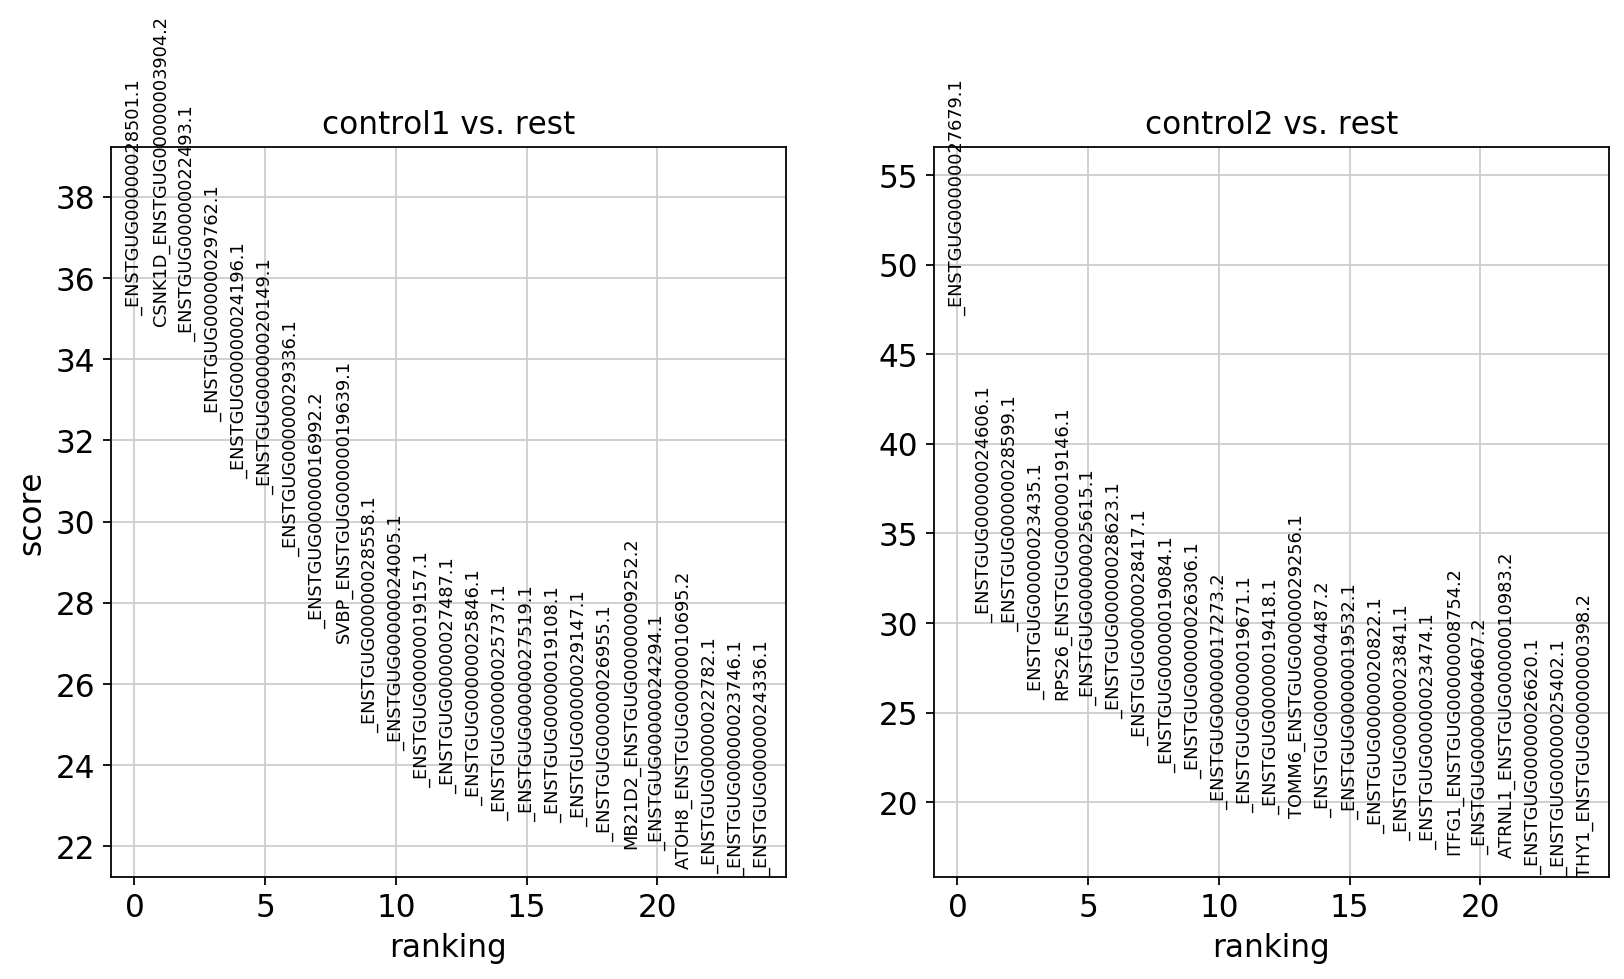

In [59]:
sc.tl.rank_genes_groups(adata_control, groupby='batch', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata_control, n_genes=25, sharey=False, save=False)

In [60]:
ctrl_markers = pd.DataFrame(adata_control.uns['rank_genes_groups']['names']).head(10)
ctrl_markers

control1                    control2
0        _ENSTGUG00000028501.1       _ENSTGUG00000027679.1
1  CSNK1D_ENSTGUG00000003904.2       _ENSTGUG00000024606.1
2        _ENSTGUG00000022493.1       _ENSTGUG00000028599.1
3        _ENSTGUG00000029762.1       _ENSTGUG00000023435.1
4        _ENSTGUG00000024196.1  RPS26_ENSTGUG00000019146.1
5        _ENSTGUG00000020149.1       _ENSTGUG00000025615.1
6        _ENSTGUG00000029336.1       _ENSTGUG00000028623.1
7        _ENSTGUG00000016992.2       _ENSTGUG00000028417.1
8    SVBP_ENSTGUG00000019639.1       _ENSTGUG00000019084.1
9        _ENSTGUG00000028558.1       _ENSTGUG00000026306.1

Top 5 control 1:  
_ENSTGUG00000028501.1 novel gene  
CSNK1D_ENSTGUG00000003904.2 casein kinase 1 delta  
_ENSTGUG00000022493.1 novel gene  
_ENSTGUG00000029762.1 novel gene  
_ENSTGUG00000024196.1 novel gene  

Top 5 control 2:  
_ENSTGUG00000027679.1 ribonuclease kappa  
_ENSTGUG00000024606.1 novel gene  
_ENSTGUG00000028599.1 ribonuclease kappa   
_ENSTGUG00000023435.1 novel gene  
RPS26_ENSTGUG00000019146.1 ribosomal protein S26   

## Experiment

... storing 'species' as categorical
... storing 'batch' as categorical
... storing 'arm' as categorical


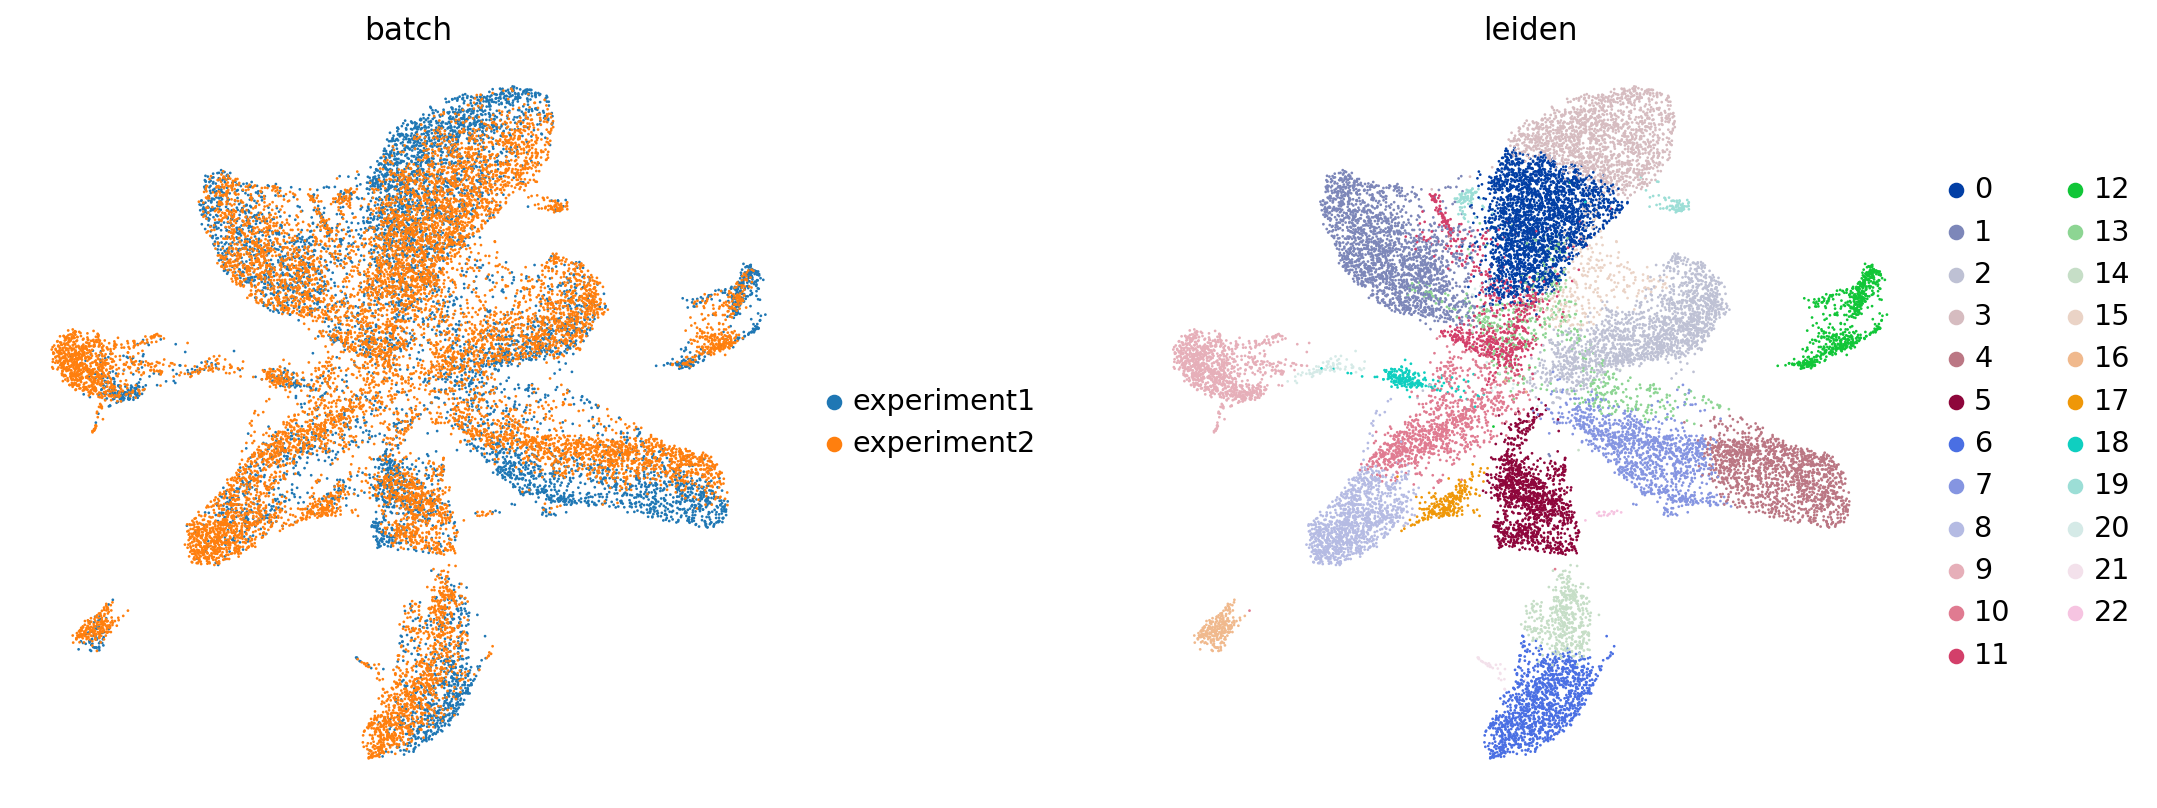

In [61]:
# Plot UMAP and color by Leiden clusters and batch
sc.pl.umap(adata_experiment, 
           color=["batch", "leiden"],
           wspace=0.3
          )

In [62]:
# Normalize each celltype count to total number of cells in that batch by dividing
df_experiment = (adata_experiment.obs.groupby("leiden")["batch"].value_counts() / adata_experiment.obs.groupby("batch")["species"].count()).unstack().fillna(0)
# The above returns a categorical dataframe, so we will convert the columns to strings
df_experiment.columns = df_experiment.columns.astype(str)

df_experiment["total normalized count"] = df_experiment.sum(axis=1).values

df_experiment["experiment1_fraction"] = (df_experiment["experiment1"] / df_experiment["total normalized count"]).values
df_experiment["experiment2_fraction"] = (df_experiment["experiment2"] / df_experiment["total normalized count"]).values

df_experiment["total number of cells"] = adata_experiment.obs.groupby("leiden").size().values.astype(int)

df_experiment.head()

batch   experiment1  experiment2  total normalized count  \
leiden                                                     
0          0.134570     0.125081                0.259652   
1          0.110044     0.094320                0.204364   
2          0.079678     0.093994                0.173672   
3          0.117830     0.055094                0.172925   
4          0.083961     0.062012                0.145972   

batch   experiment1_fraction  experiment2_fraction  total number of cells  
leiden                                                                     
0                   0.518273              0.481727                   2574  
1                   0.538472              0.461528                   2007  
2                   0.458785              0.541215                   1769  
3                   0.681397              0.318603                   1585  
4                   0.575182              0.424818                   1409

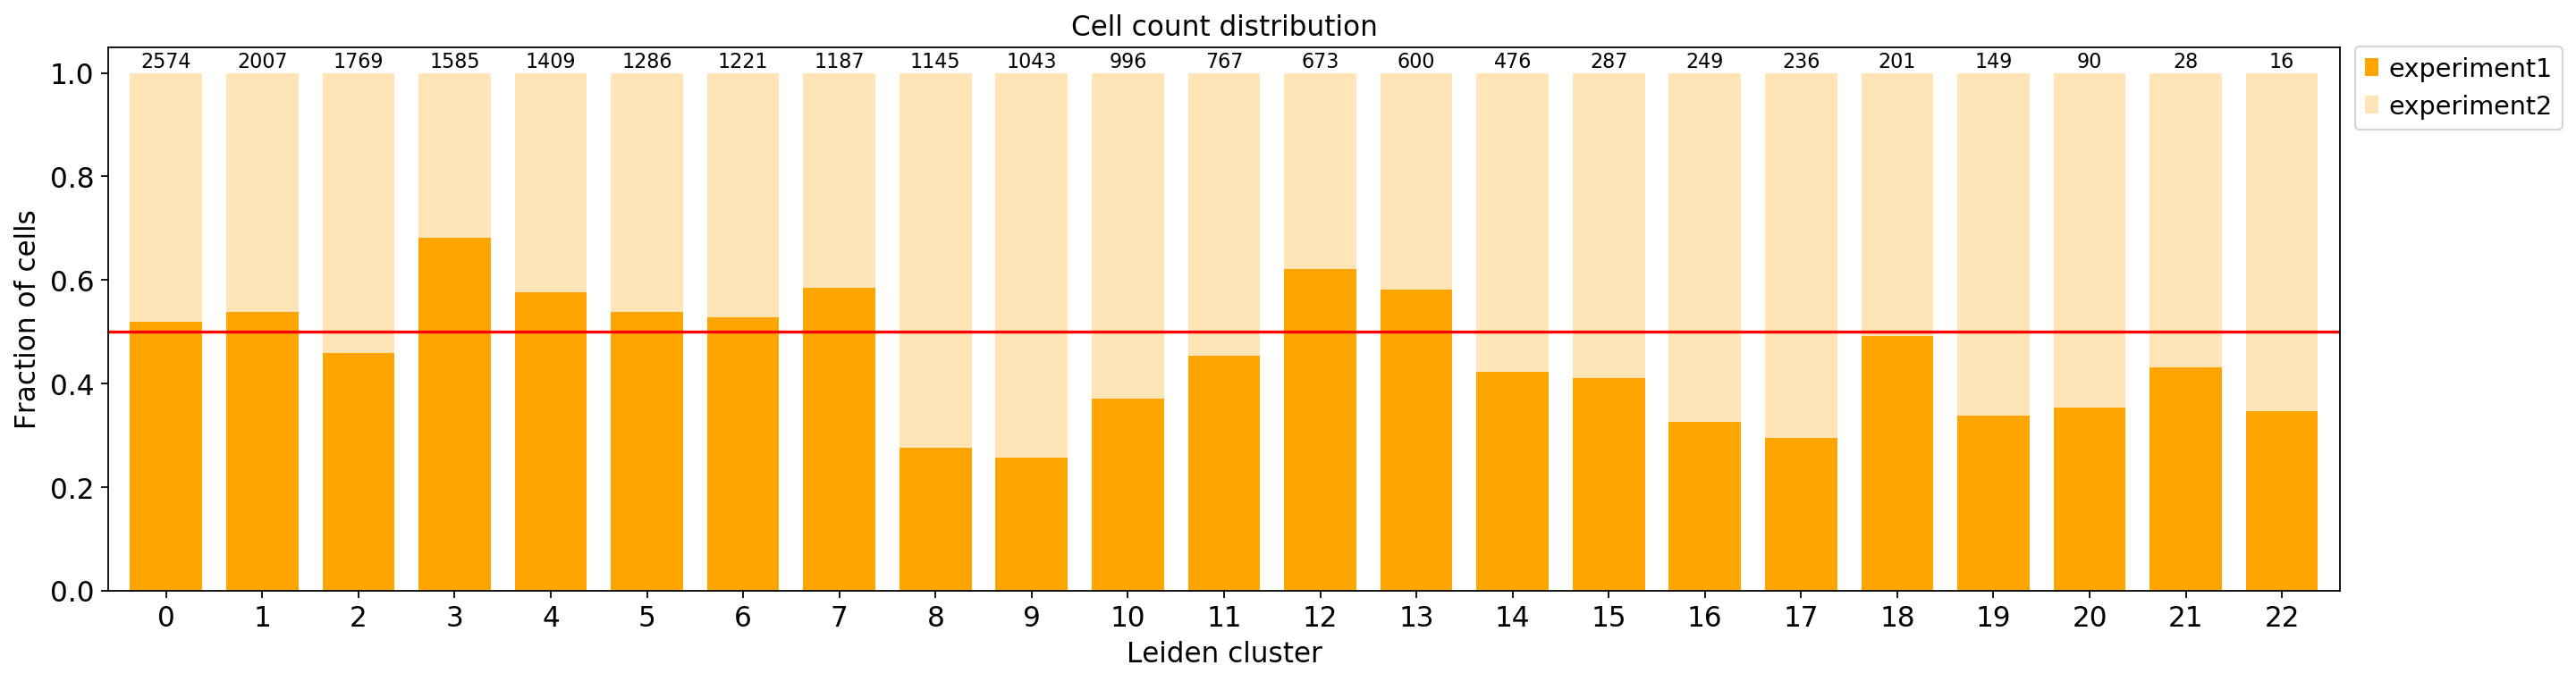

In [63]:
fig, ax = plt.subplots(figsize=(20,5))

clusters = df_experiment.index.values
width = 0.75

ax.bar(clusters, df_experiment["experiment1_fraction"].values, width, color="orange", label="experiment1")
ax.bar(clusters, df_experiment["experiment2_fraction"].values, width, bottom=df_experiment["experiment1_fraction"].values, color="moccasin", label="experiment2")

cellcounts = df_experiment["total number of cells"].values
# Add total cell count above each bar
for index, value in enumerate(cellcounts):
    ax.text(x = index, y = 1.01, s = value, size = 10, ha='center')

ax.set_xticklabels(clusters, rotation = 0, ha="center")
ax.legend(bbox_to_anchor=(1.001, 1.025), loc='upper left')

ax.set(**{
    "title": "Cell count distribution",
    "ylabel": "Fraction of cells",
    "xlabel": "Leiden cluster"
})

ax.axhline(y=0.5, color='r', linestyle='-')

ax.margins(x=0.01)
ax.grid(False) 

fig.show()

The batch effect seems to be a little worse for the experiment batches, but for both conditions each cell type includes cells from all replicates which is good. As expected, control1 and experiment2 are overrepresented due to a higher total cellcount.

### Are there DE genes between the two experiment batches?

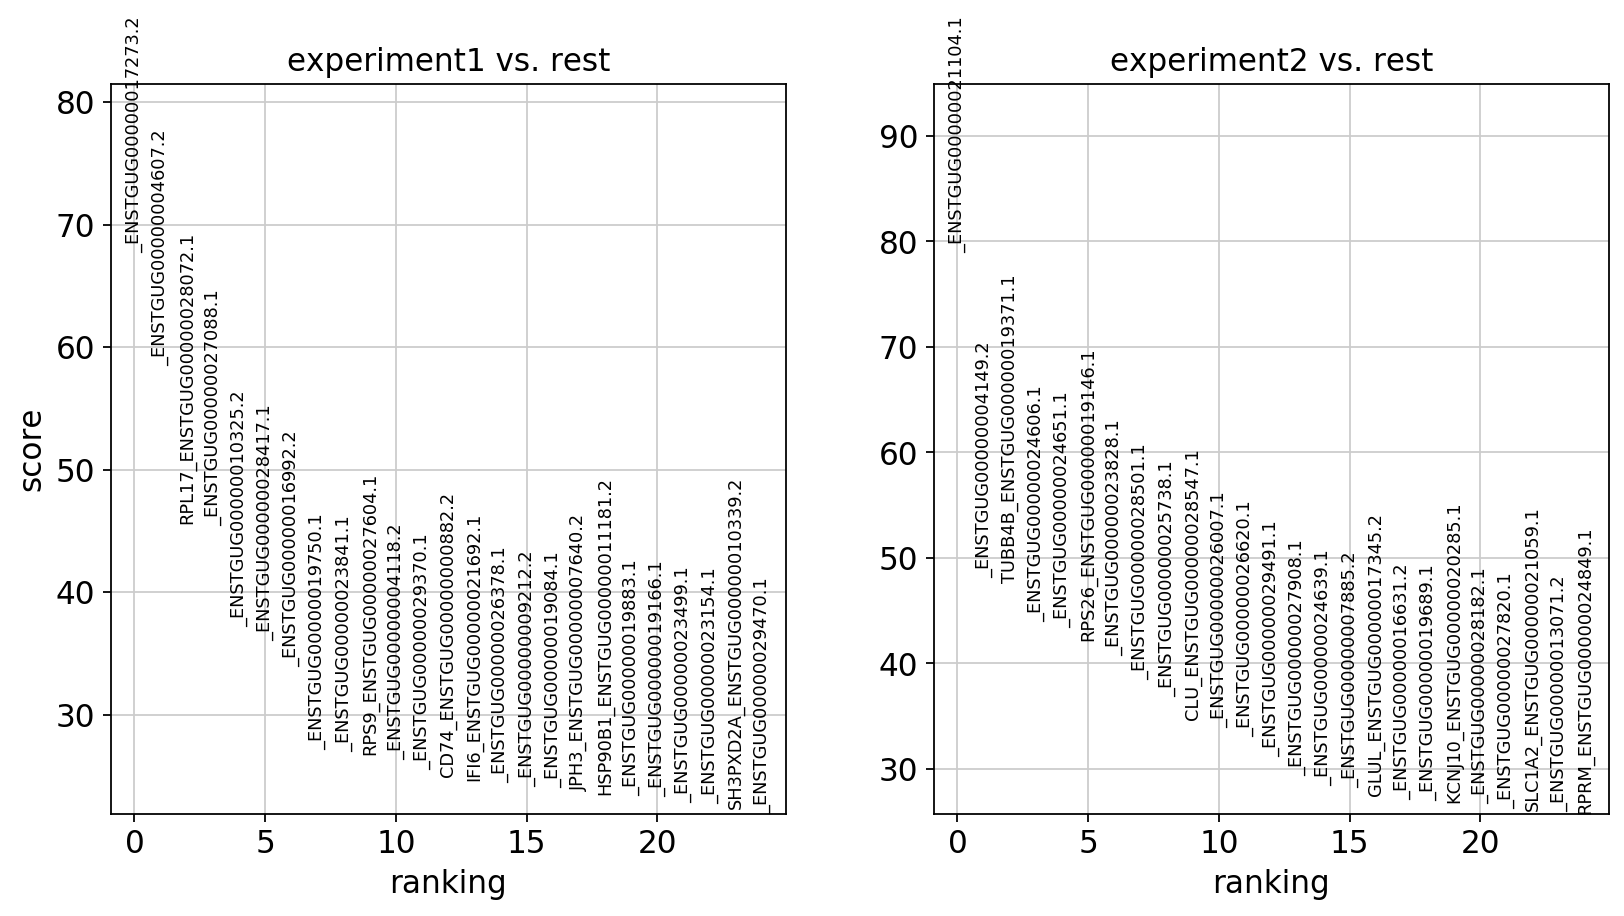

In [64]:
sc.tl.rank_genes_groups(adata_experiment, groupby='batch', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata_experiment, n_genes=25, sharey=False, save=False)

In [65]:
exp_markers = pd.DataFrame(adata_experiment.uns['rank_genes_groups']['names']).head(10)
exp_markers

experiment1                  experiment2
0       _ENSTGUG00000017273.2        _ENSTGUG00000021104.1
1       _ENSTGUG00000004607.2        _ENSTGUG00000004149.2
2  RPL17_ENSTGUG00000028072.1  TUBB4B_ENSTGUG00000019371.1
3       _ENSTGUG00000027088.1        _ENSTGUG00000024606.1
4       _ENSTGUG00000010325.2        _ENSTGUG00000024651.1
5       _ENSTGUG00000028417.1   RPS26_ENSTGUG00000019146.1
6       _ENSTGUG00000016992.2        _ENSTGUG00000023828.1
7       _ENSTGUG00000019750.1        _ENSTGUG00000028501.1
8       _ENSTGUG00000023841.1        _ENSTGUG00000025738.1
9   RPS9_ENSTGUG00000027604.1     CLU_ENSTGUG00000028547.1

Top 5 DE genes in exp 1:  
_ENSTGUG00000017273.2 novel gene  
_ENSTGUG00000004607.2 novel gene  
RPL17_ENSTGUG00000028072.1 ribosomal protein L17  
_ENSTGUG00000027088.1 novel gene  
_ENSTGUG00000010325.2 novel gene  

Top 5 DE genes in exp 2:  
_ENSTGUG00000021104.1 novel gene  
_ENSTGUG00000004149.2 small nuclear ribonucleoprotein G  
TUBB4B_ENSTGUG00000019371.1 tubulin beta-4B chain  
_ENSTGUG00000024606.1 novel gene  
_ENSTGUG00000024651.1 novel gene  

___

# Within replicate batch correction with scvi

### Batch correction of control replicates with scvi

Use adata_control_scvi (instead of adata_control), because scvi takes unnormalized counts. Set up and train model:

In [66]:
scvi.data.setup_anndata(adata_control_scvi, batch_key="batch")

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 15810 cells, 22151 vars, 2        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [67]:
# model_ctrl = scvi.model.SCVI(adata_control_scvi)
# model_ctrl.train()
# model_ctrl.save("control_scvi", overwrite=False)

In [68]:
# Load existing model
model_ctrl = scvi.model.SCVI.load("control_scvi", adata_control_scvi)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 15810 cells, 22151 vars, 2        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


Store the outputs of scvi-tools back into the original anndata to permit interoperability with Scanpy:

In [69]:
adata_control_scvi.obsm["X_scvi"] = model_ctrl.get_latent_representation()
adata_control_scvi.layers["scvi_expr"] = model_ctrl.get_normalized_expression(adata_control_scvi, n_samples=5, return_mean=True)
adata_control_scvi.layers["scvi_normalized"] = model_ctrl.get_normalized_expression(library_size=10e4)

#### Exploratory analysis of batch effect within controls after scvi correction

In [70]:
sc.pp.neighbors(adata_control_scvi, use_rep="X_scvi", metric="correlation")
sc.tl.leiden(adata_control_scvi, key_added="leiden_scvi", resolution=1.2)
sc.tl.umap(adata_control_scvi, min_dist=0.4)

In [71]:
adata_control_scvi

AnnData object with n_obs × n_vars = 15810 × 22151
    obs: 'species', 'batch', 'n_counts_processed', 'batch_index', 'n_counts_raw', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scvi'
    var: 'gene_name'
    uns: '_scvi', 'neighbors', 'leiden', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'scvi_expr', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

... storing 'species' as categorical
... storing 'batch' as categorical


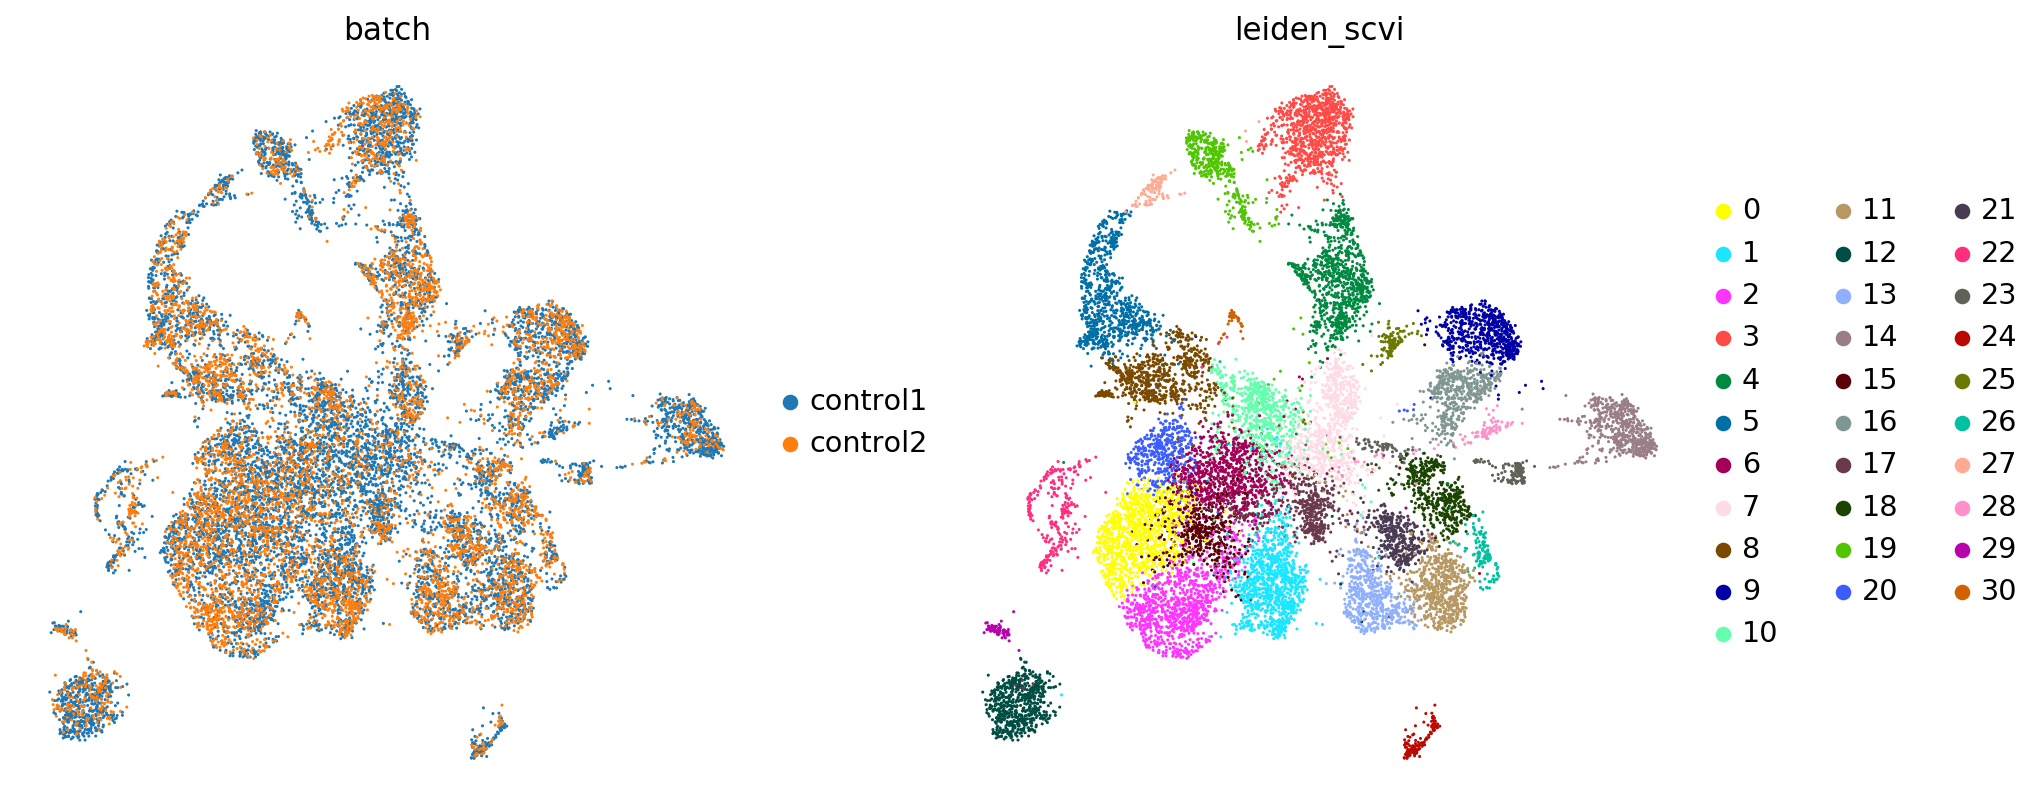

In [72]:
sc.pl.umap(
    adata_control_scvi,
    color=["batch", "leiden_scvi"],
    frameon=False,
    ncols=2
)

In [73]:
# Normalize each celltype count to total number of cells in that batch by dividing
df_control_2 = (adata_control_scvi.obs.groupby("leiden_scvi")["batch"].value_counts() / adata_control_scvi.obs.groupby("batch")["species"].count()).unstack().fillna(0)
# The above returns a categorical dataframe, so we will convert the columns to strings
df_control_2.columns = df_control_2.columns.astype(str)

df_control_2["total normalized count"] = df_control_2.sum(axis=1).values

df_control_2["control1_fraction"] = (df_control_2["control1"] / df_control_2["total normalized count"]).values
df_control_2["control2_fraction"] = (df_control_2["control2"] / df_control_2["total normalized count"]).values

df_control_2["total number of cells"] = adata_control_scvi.obs.groupby("leiden_scvi").size().values.astype(int)

df_control_2.head()

batch        control1  control2  total normalized count  control1_fraction  \
leiden_scvi                                                                  
0            0.062686  0.079047                0.141733           0.442280   
1            0.057974  0.068629                0.126603           0.457919   
2            0.052238  0.073425                0.125663           0.415700   
3            0.059613  0.054738                0.114351           0.521316   
4            0.046502  0.075079                0.121581           0.382479   

batch        control2_fraction  total number of cells  
leiden_scvi                                            
0                     0.557720                   1090  
1                     0.542081                    981  
2                     0.584300                    954  
3                     0.478684                    913  
4                     0.617521                    908

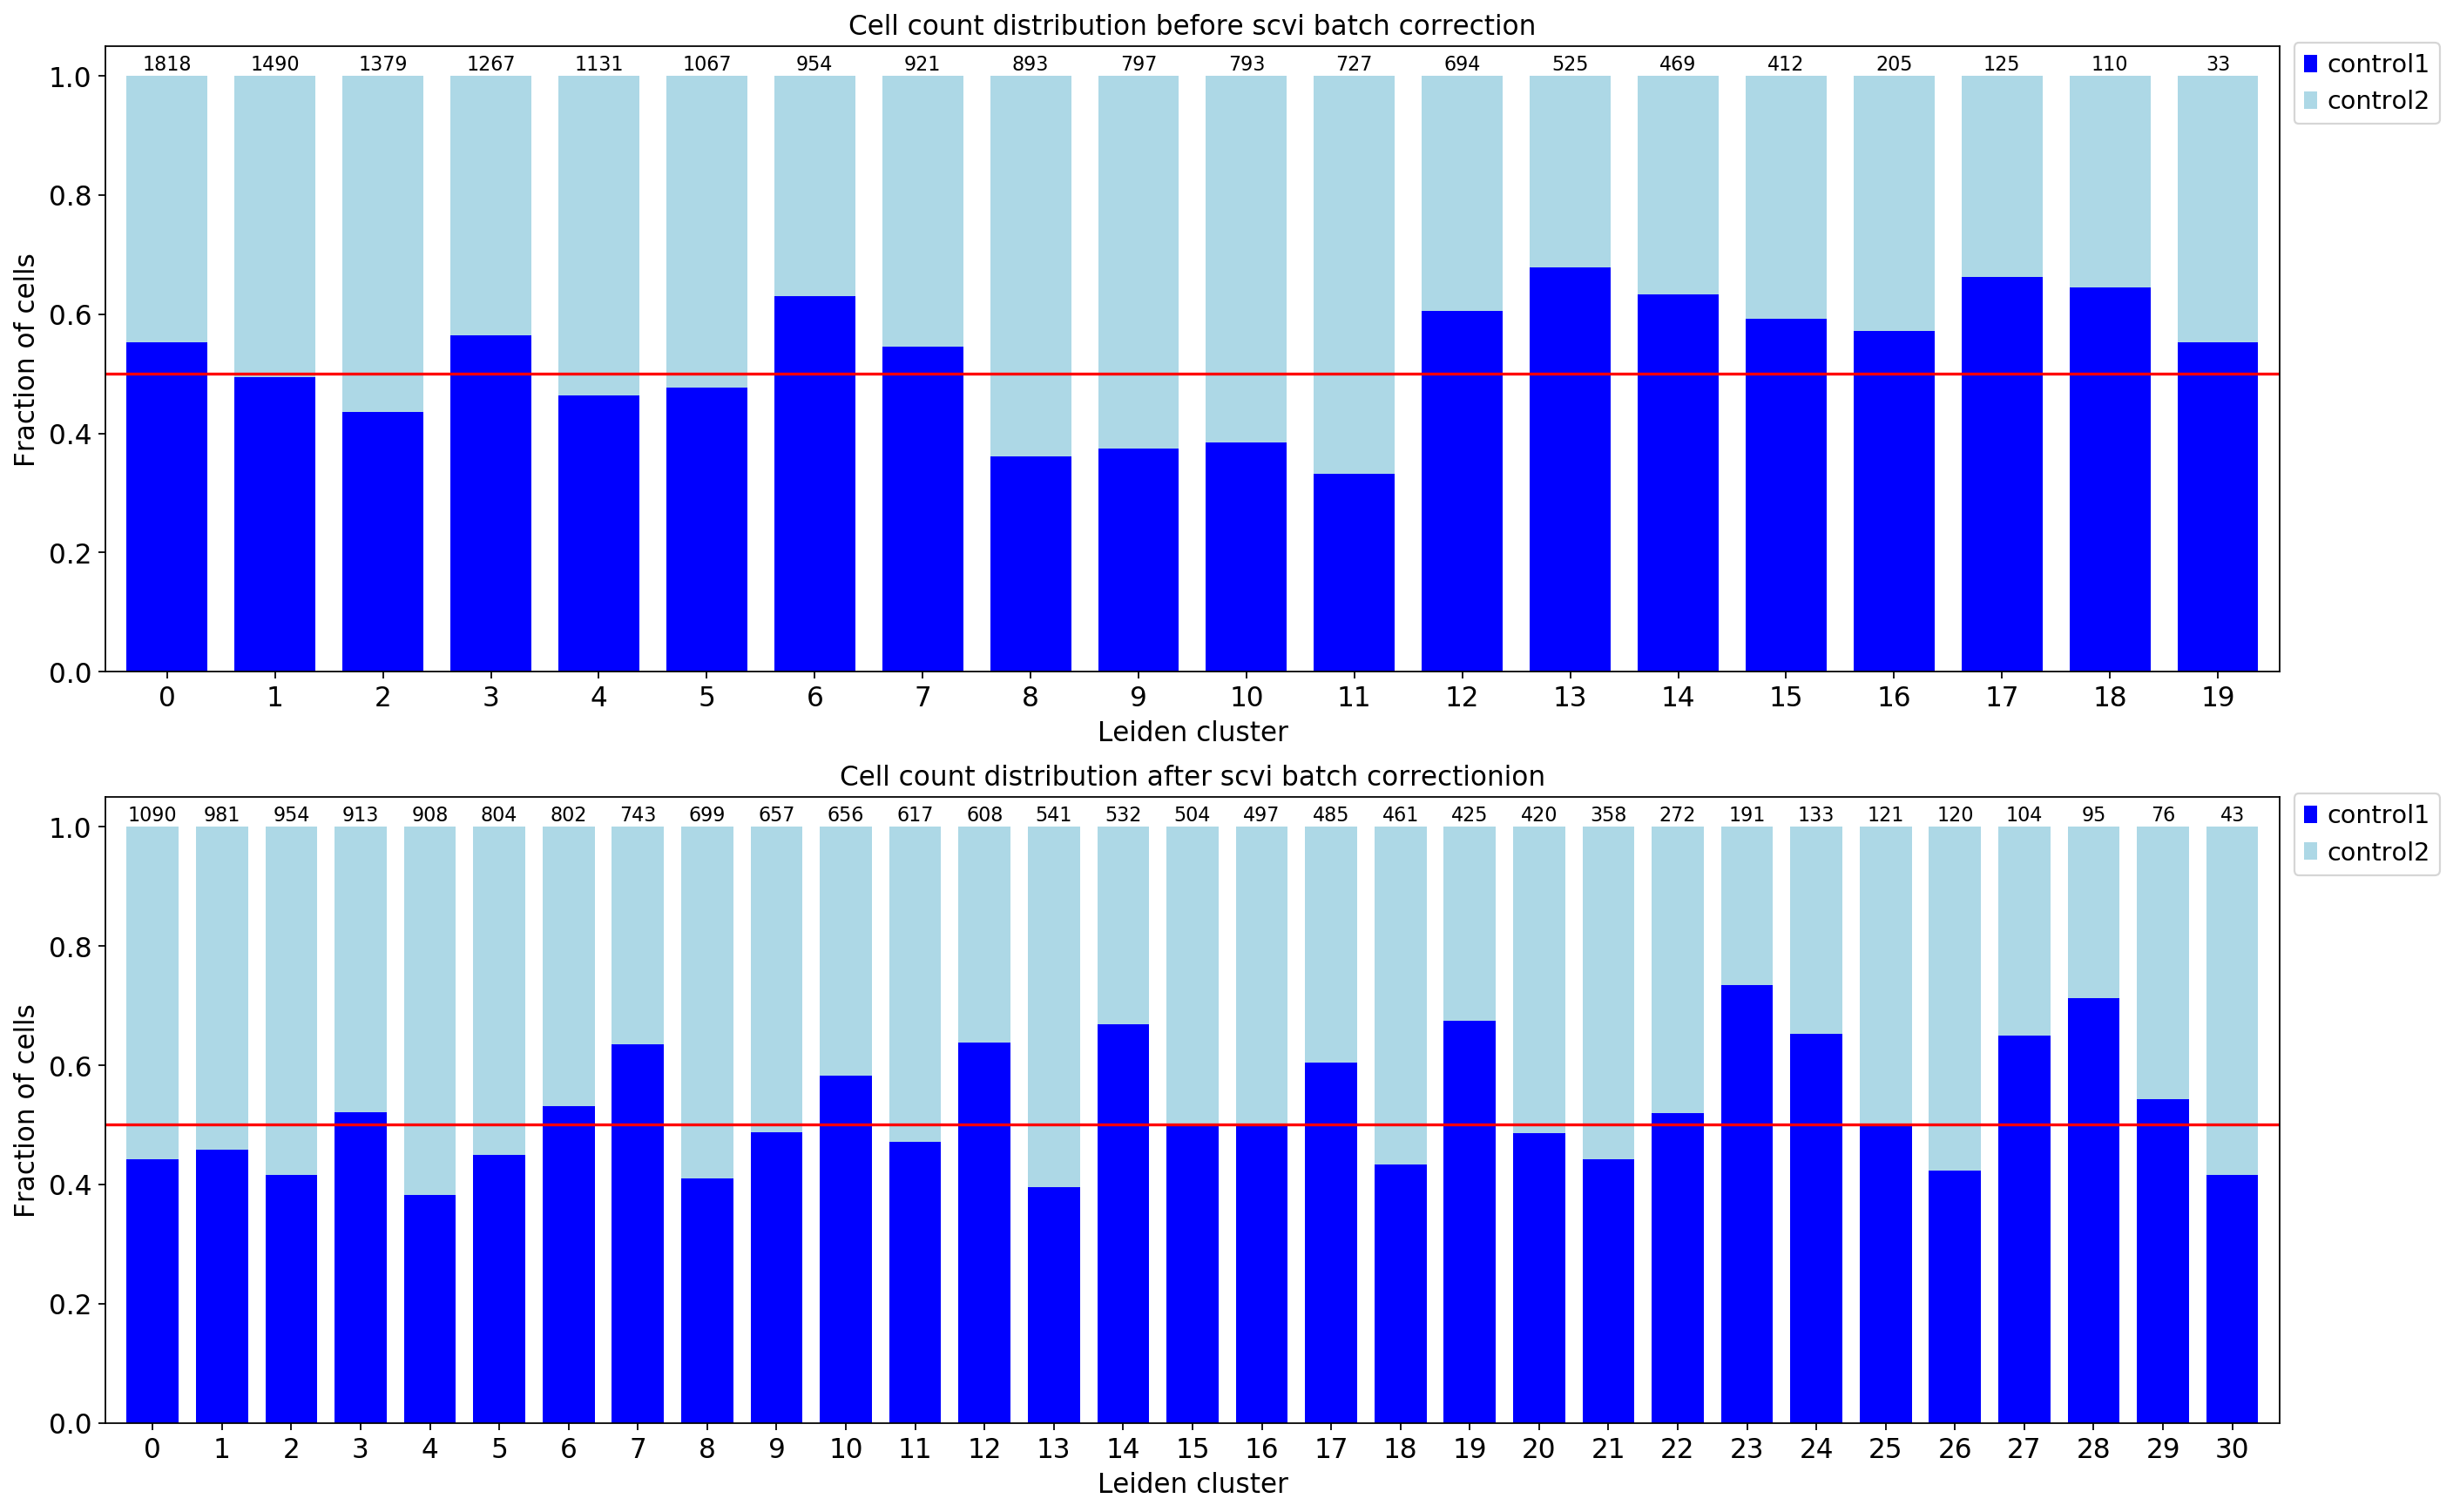

In [74]:
fig, axs = plt.subplots(figsize=(20,13), nrows=2)

dfs = [df_control, df_control_2]
titles = ["before scvi batch correction", "after scvi batch correctionion"]
i=0

for ax,df in zip(axs, dfs):
    clusters = df.index.values
    width = 0.75

    ax.bar(clusters, df["control1_fraction"].values, width, color="blue", label="control1")
    ax.bar(clusters, df["control2_fraction"].values, width, bottom=df["control1_fraction"].values, color="lightblue", label="control2")
    
    cellcounts = df["total number of cells"].values
    # Add total cell count above each bar
    for index, value in enumerate(cellcounts):
        ax.text(x = index, y = 1.01, s = value, size = 10, ha='center')

    ax.set_xticklabels(clusters, rotation = 0, ha="center")
    ax.legend(bbox_to_anchor=(1.001, 1.025), loc='upper left')

    ax.set(**{
        "title": "Cell count distribution {}".format(titles[i]),
        "ylabel": "Fraction of cells",
        "xlabel": "Leiden cluster"
    })
    
    i+=1

    ax.axhline(y=0.5, color='r', linestyle='-')

    ax.margins(x=0.01)
    ax.grid(False)

fig.show()

### Batch correction of experiment replicates with scvi:

In [75]:
scvi.data.setup_anndata(adata_experiment_scvi, batch_key="batch")

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 19994 cells, 22151 vars, 2        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [76]:
# model_exp = scvi.model.SCVI(adata_experiment_scvi)
# model_exp.train()
# model_exp.save("experiment_scvi", overwrite=False)

In [77]:
# Load existing model
model_exp = scvi.model.SCVI.load("experiment_scvi", adata_experiment_scvi)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 19994 cells, 22151 vars, 2        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


Store the outputs of scvi-tools back into the original anndata to permit interoperability with Scanpy:

In [78]:
adata_experiment_scvi.obsm["X_scvi"] = model_exp.get_latent_representation()
adata_experiment_scvi.layers["scvi_expr"] = model_exp.get_normalized_expression(adata_experiment_scvi, n_samples=5, return_mean=True)
adata_experiment_scvi.layers["scvi_normalized"] = model_exp.get_normalized_expression(library_size=10e4)

#### Exploratory analysis of batch effect within experiment batches after scvi correction

In [79]:
sc.pp.neighbors(adata_experiment_scvi, use_rep="X_scvi", metric="correlation")
sc.tl.leiden(adata_experiment_scvi, key_added="leiden_scvi", resolution=1.2)
sc.tl.umap(adata_experiment_scvi, min_dist=0.4)

... storing 'species' as categorical
... storing 'batch' as categorical
... storing 'arm' as categorical


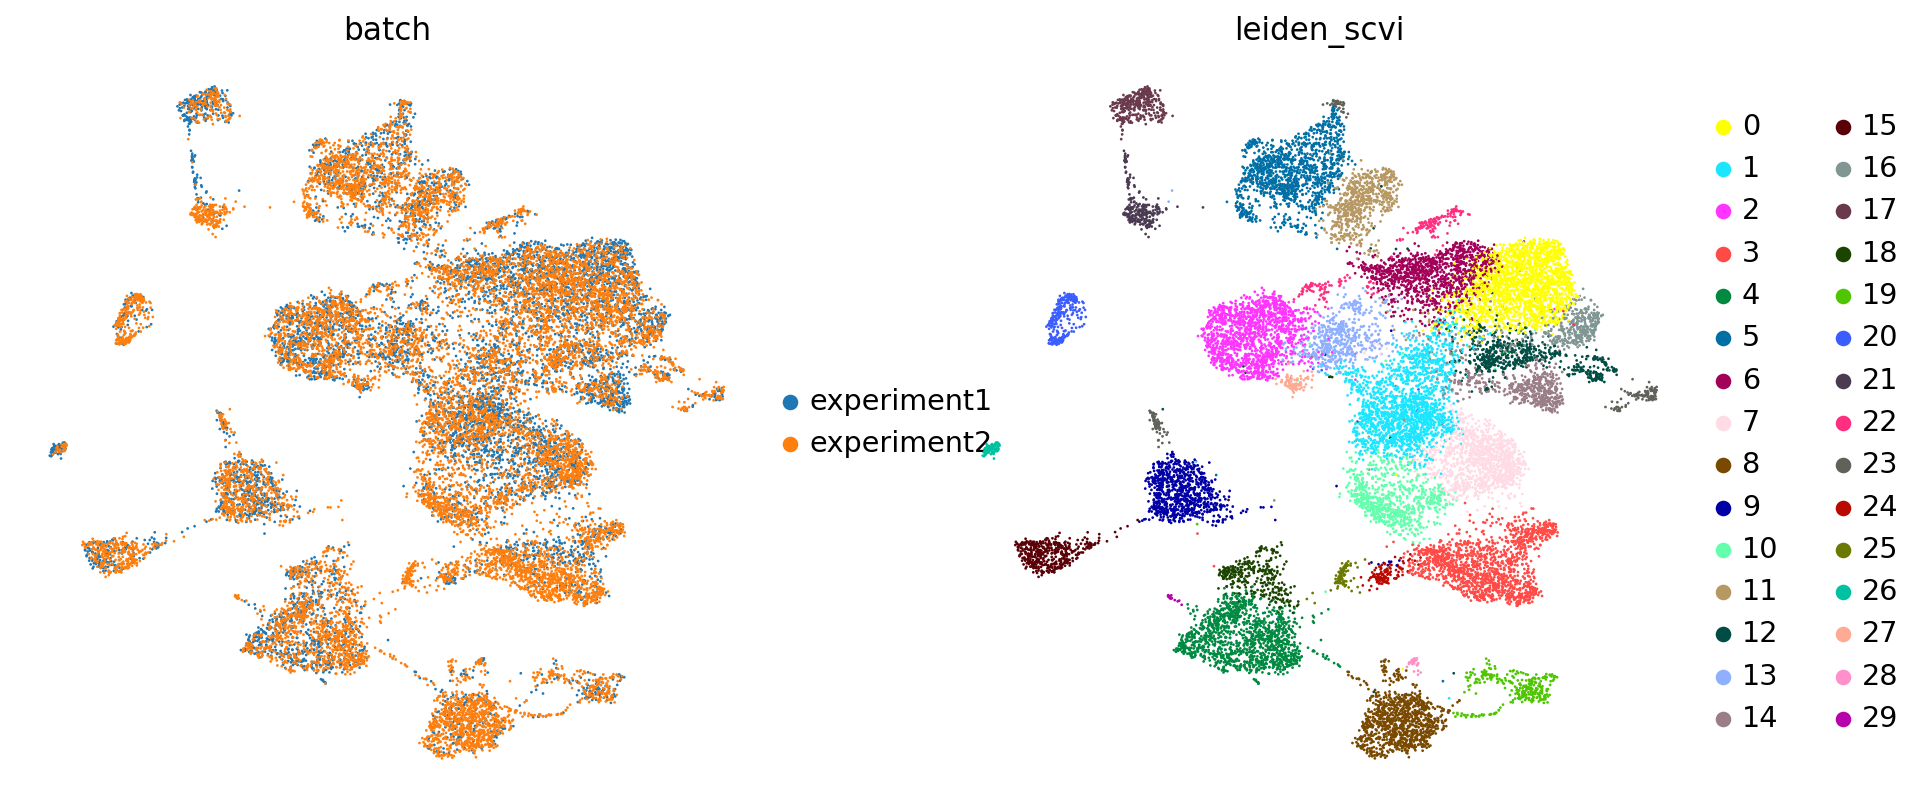

In [80]:
sc.pl.umap(
    adata_experiment_scvi,
    color=["batch", "leiden_scvi"],
    frameon=False,
    ncols=2
)

In [81]:
# Normalize each celltype count to total number of cells in that batch by dividing
df_experiment_2 = (adata_experiment_scvi.obs.groupby("leiden_scvi")["batch"].value_counts() / adata_experiment_scvi.obs.groupby("batch")["species"].count()).unstack().fillna(0)
# The above returns a categorical dataframe, so we will convert the columns to strings
df_experiment_2.columns = df_experiment_2.columns.astype(str)

df_experiment_2["total normalized count"] = df_experiment_2.sum(axis=1).values

df_experiment_2["experiment1_fraction"] = (df_experiment_2["experiment1"] / df_experiment_2["total normalized count"]).values
df_experiment_2["experiment2_fraction"] = (df_experiment_2["experiment2"] / df_experiment_2["total normalized count"]).values

df_experiment_2["total number of cells"] = adata_experiment_scvi.obs.groupby("leiden_scvi").size().values.astype(int)

df_experiment_2.head()

batch        experiment1  experiment2  total normalized count  \
leiden_scvi                                                     
0               0.115105     0.089600                0.204705   
1               0.106670     0.082194                0.188864   
2               0.079419     0.067871                0.147290   
3               0.045160     0.086833                0.131992   
4               0.070594     0.069255                0.139849   

batch        experiment1_fraction  experiment2_fraction  total number of cells  
leiden_scvi                                                                     
0                        0.562298              0.437702                   1988  
1                        0.564798              0.435202                   1832  
2                        0.539200              0.460800                   1446  
3                        0.342138              0.657862                   1415  
4                        0.504790              0.495210                   1395

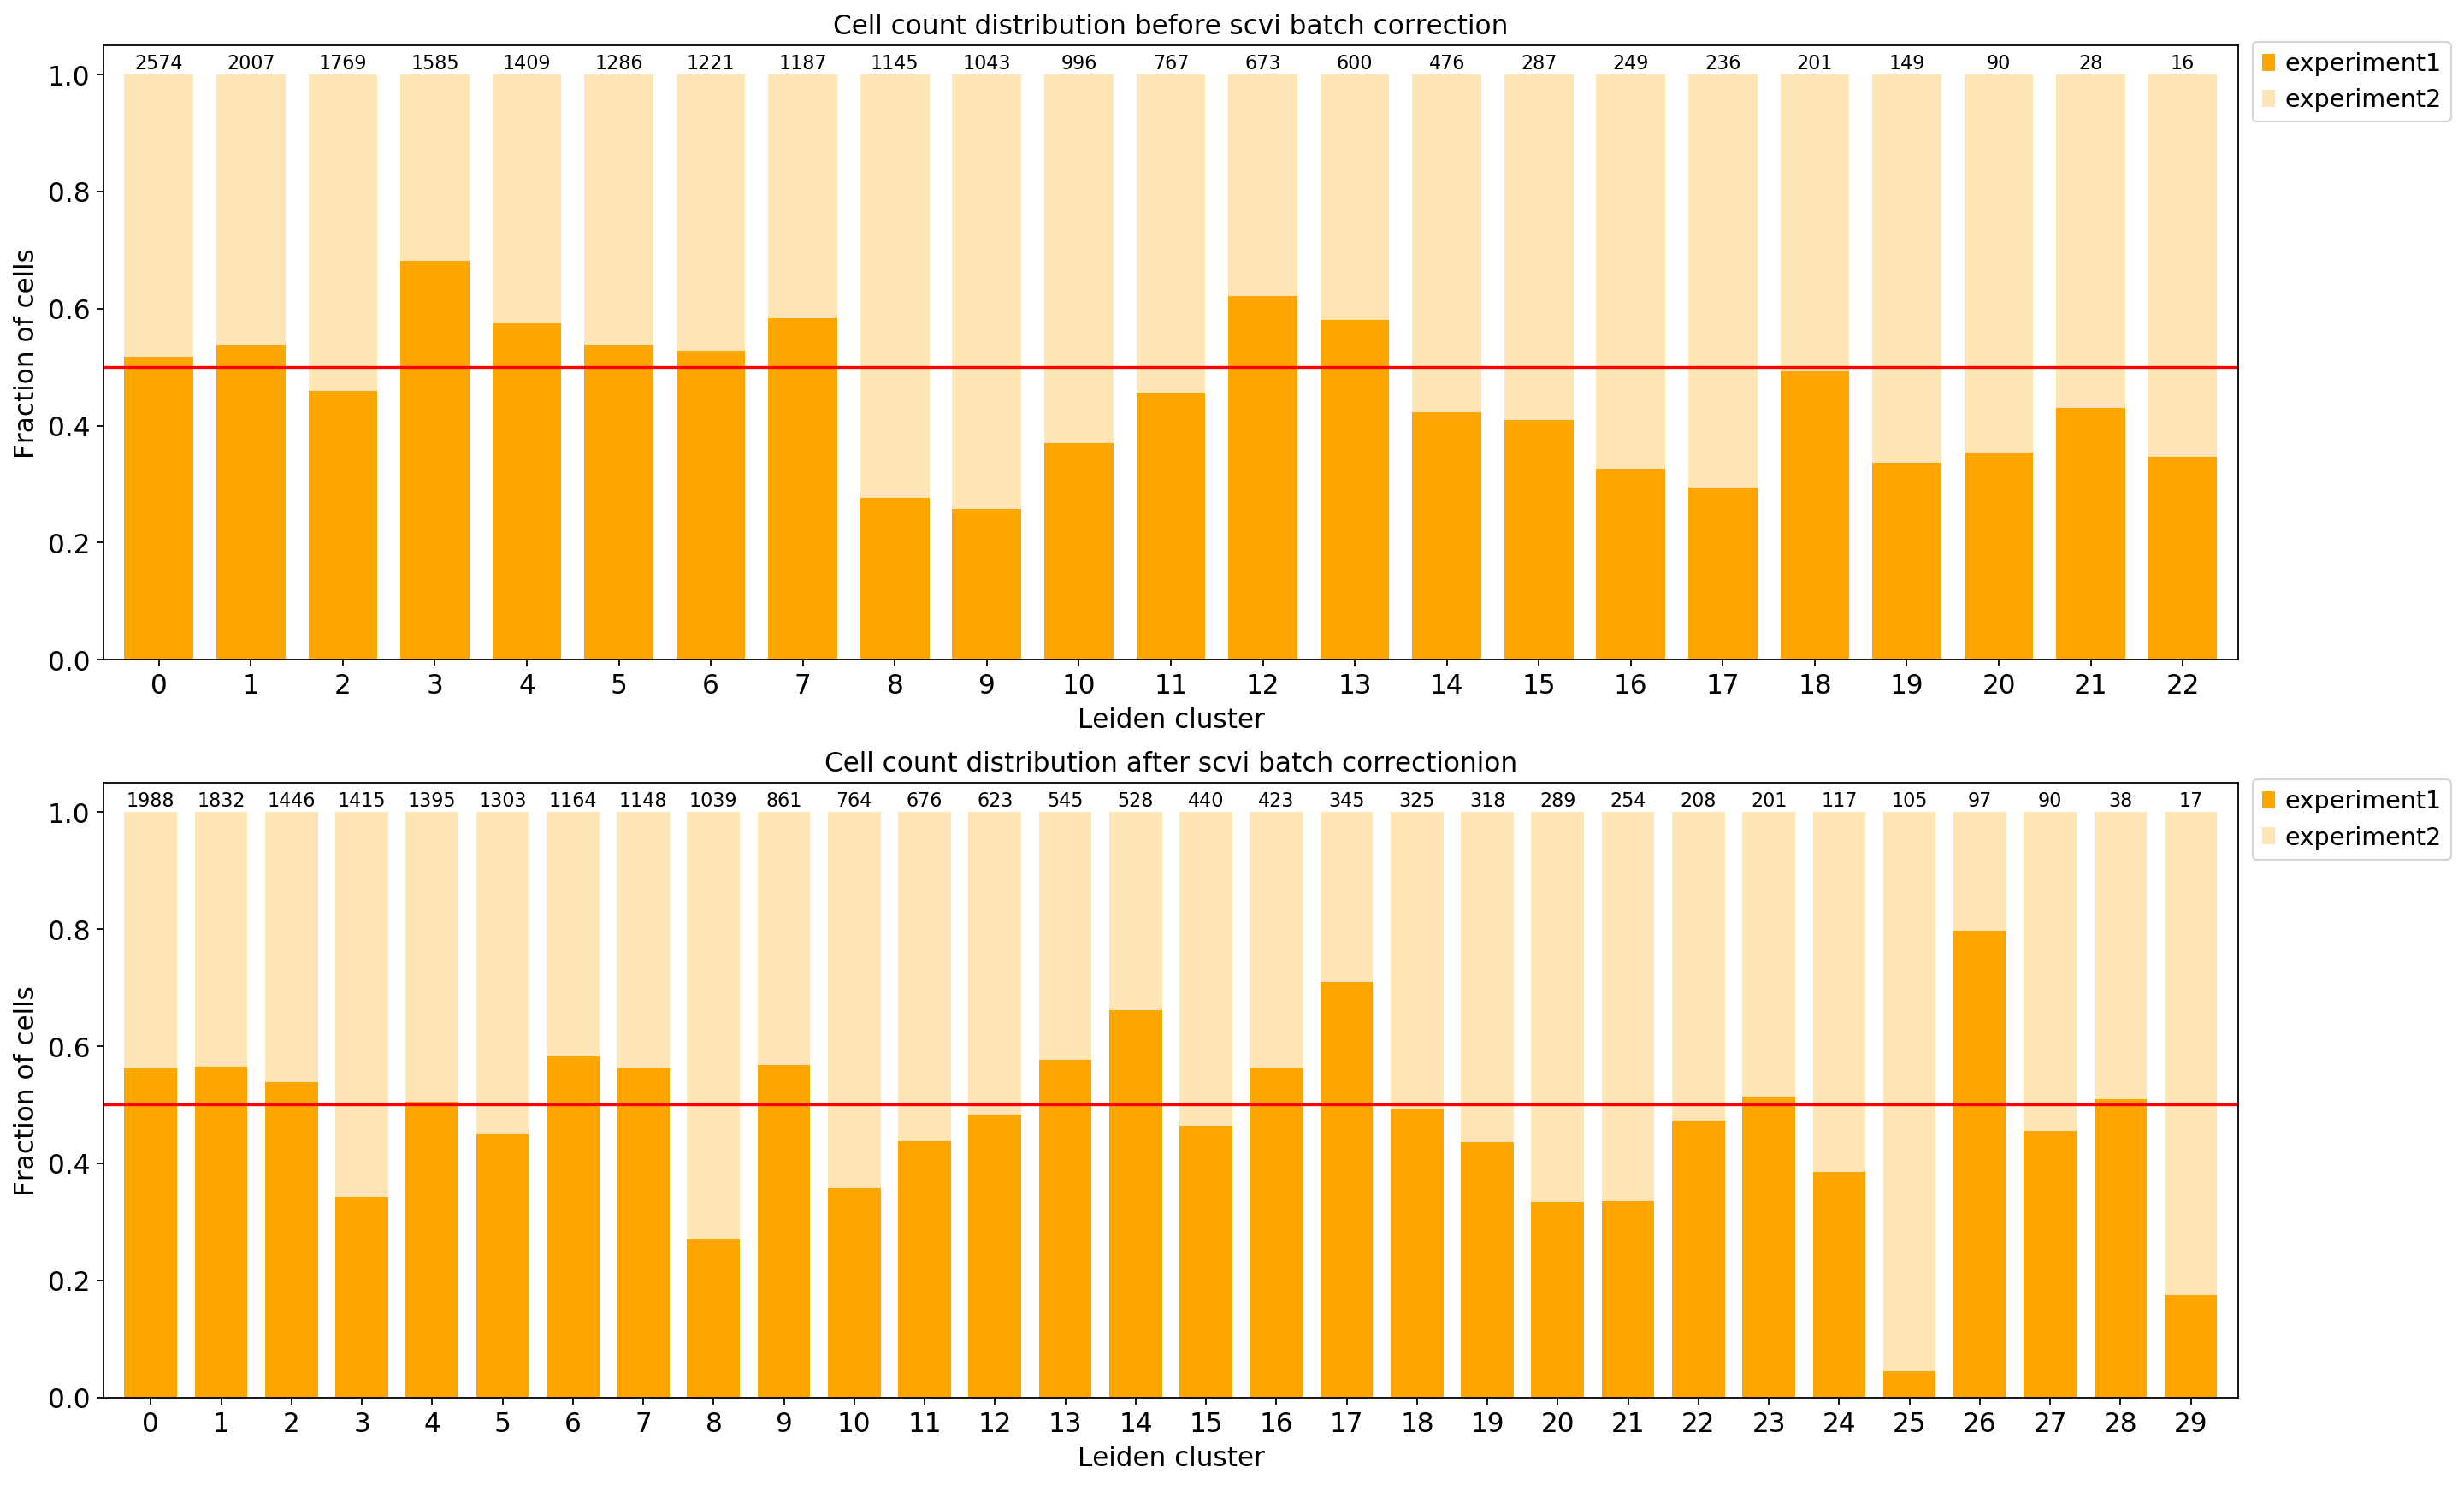

In [82]:
fig, axs = plt.subplots(figsize=(20,13), nrows=2)

dfs = [df_experiment, df_experiment_2]
titles = ["before scvi batch correction", "after scvi batch correctionion"]
i=0

for ax,df in zip(axs, dfs):
    clusters = df.index.values
    width = 0.75

    ax.bar(clusters, df["experiment1_fraction"].values, width, color="orange", label="experiment1")
    ax.bar(clusters, df["experiment2_fraction"].values, width, bottom=df["experiment1_fraction"].values, color="moccasin", label="experiment2")
    
    cellcounts = df["total number of cells"].values
    # Add total cell count above each bar
    for index, value in enumerate(cellcounts):
        ax.text(x = index, y = 1.01, s = value, size = 10, ha='center')

    ax.set_xticklabels(clusters, rotation = 0, ha="center")
    ax.legend(bbox_to_anchor=(1.001, 1.025), loc='upper left')

    ax.set(**{
        "title": "Cell count distribution {}".format(titles[i]),
        "ylabel": "Fraction of cells",
        "xlabel": "Leiden cluster"
    })
    
    i+=1

    ax.axhline(y=0.5, color='r', linestyle='-')

    ax.margins(x=0.01)
    ax.grid(False)

fig.show()

It looks like scvi batch correction did not do much here (maybe because the batch effect was small to start with?).

___

# Concatenate scvi batch corrected datasets and save AnnData object

In [83]:
# Join = outer uses union of datasets (not just intersection); empty values will be filled with np.nan
adata_scvi = adata_control_scvi.concatenate(adata_experiment_scvi,
                             join='outer', 
                             batch_key='batch_index', 
                             batch_categories=None, 
                             uns_merge=None,
                             fill_value=np.nan)

In [85]:
# adata_scvi.write("../../finchseq_data/all_leiden_scvi.h5ad")

... storing 'batch' as categorical
... storing 'leiden_scvi' as categorical
... storing 'arm' as categorical


___

## Perform scvi differential expression?
https://docs.scvi-tools.org/en/stable/user_guide/notebooks/api_overview.html